# **Prediksi Timbulan Sampah Indonesia Menggunakan Pendekatan Ensemble Learning: Analisis Faktor Sosio-Ekonomi dan Infrastruktur**

# *SDGs 11 Kota dan Pemukiman yang Berkelanjutan*

### Nama Kelompok
*   Zaid Helsinki Putra (E1E123054)
*   Ramlia Ramadani Sudin (E1E123016)






In [ ]:
# **DATA WRANGLING**

# 0. IMPORT UMUM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# Format plotting
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

## **1.1 Gathering Data**

from google.colab import drive

# --- Langkah 1: Mounting Google Drive ---
drive.mount('/content/drive')

# --- Langkah 2: Tentukan Jalur Dasar (BASE PATH) ---
BASE_PATH = '/content/drive/MyDrive/Dataset Data Science/'

# Daftar nama file yang digunakan
FILE_PDRB = "PDRB_Indonesia.csv"
FILE_WASTE = "SIPSN_Waste.csv"
FILE_INFRA = "Waste_Infrastructure.csv"
FILE_POP = "Penduduk_indonesia.csv"  # File baru yang diganti

# --- 1. Load Data Timbulan Sampah (SIPSN_Waste) ---
df_waste = pd.read_csv(
    BASE_PATH + FILE_WASTE,
    skiprows=1 # Assuming the first row is still metadata
)

# --- 2. Load Data PDRB Per Kapita ---
df_pdrb = pd.read_csv(
    BASE_PATH + FILE_PDRB
)

# --- 3. Load Data Infrastruktur Sampah (Waste_Infrastructure) ---
df_infra = pd.read_csv(
    BASE_PATH + FILE_INFRA,
    skiprows=1
)

# --- 4. Load Data Penduduk (Population) - File Baru ---
df_pop = pd.read_csv(BASE_PATH + FILE_POP)

print("✅ Data Gathering (Load dari Google Drive) Selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data Gathering (Load dari Google Drive) Selesai.


## **1.2 Assessing Data**

# ***5 Baris Pertama pada Dataset***

In [ ]:
print("---1. Data PDRB Per Kapita (df_pdrb) ---")
print("Lima baris pertama:")
df_pdrb.head()

---1. Data PDRB Per Kapita (df_pdrb) ---
Lima baris pertama:


,id,kode_provinsi,nama_provinsi,pdrb_per_kapita,satuan,tahun
0,1,11,ACEH,26851.88,RIBU RUPIAH,2016
1,2,12,SUMATERA UTARA,44392.46,RIBU RUPIAH,2016
2,3,13,SUMATERA BARAT,37284.56,RIBU RUPIAH,2016
3,4,14,RIAU,104861.11,RIBU RUPIAH,2016
4,5,15,JAMBI,49494.98,RIBU RUPIAH,2016


In [ ]:
print("\n--- 2. Data Timbulan Sampah (df_waste) ---")
print("Lima baris pertama:")
df_waste.head()


--- 2. Data Timbulan Sampah (df_waste) ---
Lima baris pertama:


,Tahun,Provinsi,Kabupaten/Kota,Timbulan Sampah Harian(ton),Timbulan Sampah Tahunan(ton)
0,2019,Aceh,Kab. Aceh Selatan,95.93,"35,013.28"
1,2021,Aceh,Kab. Aceh Selatan,94.59,"34,527.10"
2,2022,Aceh,Kab. Aceh Selatan,96.49,"35,217.68"
3,2023,Aceh,Kab. Aceh Selatan,96.78,"35,323.53"
4,2024,Aceh,Kab. Aceh Selatan,95.79,"34,963.35"


In [ ]:
print("\n--- 3. Data Infrastruktur Sampah (df_infra) ---")
print("Lima baris pertama:")
df_infra.head()


--- 3. Data Infrastruktur Sampah (df_infra) ---
Lima baris pertama:


,Unnamed: 0,Tahun,P,Provinsi,Kabupaten/Kota,Nama Fasilitas,Jenis,Status,Sampahmasuk (ton/thn),Sampahmasuk Landfill (ton/thn),...,Luas Landfill Aktif (m2),Pencatatan,Jembatan Timbang,Penutupan Sampah Zona Aktif,Jml Sumur Pantau,IPL,Jml Uji Lindi,Ada Drainase,Pemanfaatan Gas Metana,Jumlah KK yang memanfaatkan gas Metana
0,NaN,2024,2,Aceh,Kab. Aceh Selatan,TPA PASIE RAJA,TPA Pemda (Non Regional),A,"12,775.00","12,775.00",...,20.00,-,Ada tapi sedang rusak,-,1,"Ada, Instalasi Pengolahan Air Lindi (IPAL) di ...",-,ADA,-,-
1,NaN,2024,2,Aceh,Kab. Aceh Tenggara,TPA SELAMAT INDAH,TPA Pemda (Non Regional),A,"10,950.00","8,760.00",...,"5,913.60",Kombinasi timbangan dengan Komputer (excel / t...,Ada tapi sedang rusak,Tidak ditutup sama sekali,4,Tidak ada Instalasi Pengolahan Air Lindi (IPAL...,-,ADA,Tidak ada. Gas Metana dibakar.,-
2,NaN,2024,2,Aceh,Kab. Aceh Timur,TPA Lhok Tujoh,TPA Pemda (Non Regional),A,"19,970.25","19,930.10",...,"42,000.00",Manual Book,Tidak Ada,Tiga hari sekali atau seminggu dua kali,-,"Ada, Instalasi Pengolahan Air Lindi (IPAL) di ...",-,TIDAK ADA,-,-
3,NaN,2024,2,Aceh,Kab. Aceh Timur,TPA BIREM BAYEUN,TPA Pemda (Non Regional),A,"8,655.98","8,615.83",...,"15,000.00",Manual Book,Tidak Ada,Tujuh hari sekali atau Seminggu Sekali,-,Tidak ada Instalasi Pengolahan Air Lindi (IPAL...,-,TIDAK ADA,-,-
4,NaN,2024,2,Aceh,Kab. Aceh Tengah,TPA Uwer Tetemi,TPA Pemda (Non Regional),A,"24,090.00","23,360.00",...,2.00,Manual Book,Tidak Ada,Tidak ditutup sama sekali,3,"Ada, Instalasi Pengolahan Air Lindi (IPAL) di ...",-,TIDAK ADA,Tidak ada. Gas Metana dibakar.,-


In [ ]:
print("\n--- 4. Data Penduduk (df_pop) ---")
print("Lima baris pertama:")
df_pop.head()


--- 4. Data Penduduk (df_pop) ---
Lima baris pertama:


,Aceh,5274.9,2021
0,Sumatera Utara,14799.4,2021
1,Sumatera Barat,5534.5,2021
2,Riau,6394.1,2021
3,Kep. Riau,2064.6,2021
4,Jambi,3548.2,2021


# ***Informasi pada Dataset***

In [ ]:
print("--- 1. Data PDRB Per Kapita (df_pdrb) ---")
print("\nInformasi Data:")
df_pdrb.info()

--- 1. Data PDRB Per Kapita (df_pdrb) ---

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               314 non-null    int64  
 1   kode_provinsi    314 non-null    int64  
 2   nama_provinsi    314 non-null    object 
 3   pdrb_per_kapita  314 non-null    float64
 4   satuan           314 non-null    object 
 5   tahun            314 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 14.8+ KB


In [ ]:
print("\n--- 2. Data Timbulan Sampah (df_waste) ---")
print("\nInformasi Data:")
df_waste.info()


--- 2. Data Timbulan Sampah (df_waste) ---

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740 entries, 0 to 1739
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Tahun                         1740 non-null   int64 
 1   Provinsi                      1740 non-null   object
 2   Kabupaten/Kota                1740 non-null   object
 3   Timbulan Sampah Harian(ton)   1740 non-null   object
 4   Timbulan Sampah Tahunan(ton)  1740 non-null   object
dtypes: int64(1), object(4)
memory usage: 68.1+ KB


In [ ]:
print("\n--- 3. Data Infrastruktur Sampah (df_infra) ---")
print("\nInformasi Data:")
df_infra.info(verbose=False)


--- 3. Data Infrastruktur Sampah (df_infra) ---

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Columns: 32 entries, Unnamed: 0 to Jumlah KK yang memanfaatkan gas Metana
dtypes: float64(1), int64(2), object(29)
memory usage: 418.9+ KB


In [ ]:
print("\n--- 4. Data Penduduk (df_pop) ---")
print("\nInformasi Data:")
df_pop.info()


--- 4. Data Penduduk (df_pop) ---

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Aceh    139 non-null    object 
 1   5274.9  139 non-null    float64
 2   2021    139 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.4+ KB


# ***Mengecek Nilai Hilang (Missing Values) pada Dataset***

In [ ]:
print("--- 1. Data PDRB Per Kapita (df_pdrb) ---")
print("\nNilai yang hilang:")
df_pdrb.isnull().sum()

--- 1. Data PDRB Per Kapita (df_pdrb) ---

Nilai yang hilang:


,0
id,0
kode_provinsi,0
nama_provinsi,0
pdrb_per_kapita,0
satuan,0
tahun,0


In [ ]:
print("\n--- 2. Data Timbulan Sampah (df_waste) ---")
print("\nNilai yang hilang:")
df_waste.isnull().sum()


--- 2. Data Timbulan Sampah (df_waste) ---

Nilai yang hilang:


,0
Tahun,0
Provinsi,0
Kabupaten/Kota,0
Timbulan Sampah Harian(ton),0
Timbulan Sampah Tahunan(ton),0


In [ ]:
print("\n--- 3. Data Infrastruktur Sampah (df_infra) ---")
print("\nNilai yang hilang (Top 5):")
df_infra.isnull().sum().sort_values(ascending=False).head(5)


--- 3. Data Infrastruktur Sampah (df_infra) ---

Nilai yang hilang (Top 5):


,0
Unnamed: 0,1675
Kelurahan,593
Kecamatan,584
Pengelola,168
Jenis,63


In [ ]:
print("\n--- 4. Data Penduduk (df_pop) ---")
print("\nNilai yang hilang:")
df_pop.isnull().sum()


--- 4. Data Penduduk (df_pop) ---

Nilai yang hilang:


,0
Aceh,0
5274.9,0
2021,0


# ***Deskripsi tentang Dataset***

In [ ]:
print("--- Data PDRB Per Kapita (df_pdrb) ---")
print("\nDeskripsi Data:")
df_pdrb.describe()

--- Data PDRB Per Kapita (df_pdrb) ---

Deskripsi Data:


,id,kode_provinsi,pdrb_per_kapita,tahun
count,314.000000,314.000000,314.000000,314.000000
mean,157.500000,48.767516,67111.958726,2020.089172
std,90.788215,26.880521,52499.151748,2.613252
min,1.000000,11.000000,16093.510000,2016.000000
25%,79.250000,19.000000,38778.992500,2018.000000
50%,157.500000,52.000000,51299.170000,2020.000000
75%,235.750000,73.000000,69090.607500,2022.000000
max,314.000000,97.000000,344349.760000,2024.000000


In [ ]:
print("\n--- 2. Data Timbulan Sampah (df_waste) ---")
print("\nDeskripsi Data:")
df_waste.describe()


--- 2. Data Timbulan Sampah (df_waste) ---

Deskripsi Data:


,Tahun
count,1740.000000
mean,2021.789655
std,1.670881
min,2018.000000
25%,2020.000000
50%,2022.000000
75%,2023.000000
max,2024.000000


In [ ]:
print("\n--- 3. Data Infrastruktur Sampah (df_infra) ---")
print("\nDeskripsi Data:")
df_infra.describe()


--- 3. Data Infrastruktur Sampah (df_infra) ---

Deskripsi Data:


,Unnamed: 0,Tahun,P
count,0.0,1675.000000,1675.000000
mean,NaN,2022.588060,1.981493
std,NaN,1.141108,0.134818
min,NaN,2019.000000,1.000000
25%,NaN,2022.000000,2.000000
50%,NaN,2023.000000,2.000000
75%,NaN,2024.000000,2.000000
max,NaN,2024.000000,2.000000


In [ ]:
print("\n--- 4. Data Penduduk (df_pop) ---")
print("\nDeskripsi Data:")
df_pop.describe()


--- 4. Data Penduduk (df_pop) ---

Deskripsi Data:


,5274.9,2021
count,139.000000,139.000000
mean,15725.042446,2022.510791
std,46190.043208,1.118791
min,701.800000,2021.000000
25%,2152.400000,2022.000000
50%,4317.400000,2023.000000
75%,8742.300000,2023.500000
max,281603.800000,2024.000000


## **1.3 Cleaning Data**

In [ ]:
# ***Pembersihan Data Secara Umum***

def to_numeric_keep_none(s):
    """Bersihkan string angka yang mengandung koma ribuan atau titik desimal,
    lalu kembalikan float. Jika tidak bisa, kembalikan np.nan."""
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float, np.number)):
        return s
    try:
        s2 = str(s).strip()
        if s2.count(',')==1 and s2.count('.')>0 and s2.rfind('.') < s2.rfind(','):
            s2 = s2.replace('.', '').replace(',', '.')
        else:
            s2 = s2.replace(',', '')
        return float(s2)
    except:
        return np.nan

def standardize_provinsi_name(df, col='Provinsi'):
    """Standarisasi nama provinsi: strip, uppercase, normalize spacing"""
    df[col] = df[col].astype(str).str.strip().str.upper().str.replace(r'\s+',' ', regex=True)
    return df

def ensure_year_int(df, col='Tahun'):
    """Konversi kolom tahun menjadi integer dengan handling missing values"""
    if col not in df.columns:
        return df

    try:
        # Konversi ke numeric dengan error handling
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Untuk pandas yang mendukung nullable integer
        try:
            df[col] = df[col].astype('Int64')
        except:
            # Fallback: konversi ke float dulu, lalu int (non-nullable)
            df[col] = df[col].fillna(0).astype(int)
            # Ganti 0 dengan NaN jika ada missing values asli
            df.loc[df[col] == 0, col] = np.nan
    except Exception as e:
        print(f"Warning: Tidak dapat mengkonversi kolom {col} ke integer: {e}")

    return df

In [ ]:
### ***Cleaning — PDRB (df_pdrb)***

df_pdrb_clean = df_pdrb.copy()

# Standardize nama provinsi
if 'nama_provinsi' in df_pdrb_clean.columns:
    df_pdrb_clean = standardize_provinsi_name(df_pdrb_clean, 'nama_provinsi')
    df_pdrb_clean.rename(columns={'nama_provinsi':'Provinsi'}, inplace=True)

# Konversi pdrb_per_kapita ke numeric
if 'pdrb_per_kapita' in df_pdrb_clean.columns:
    df_pdrb_clean['pdrb_per_kapita'] = df_pdrb_clean['pdrb_per_kapita'].apply(to_numeric_keep_none)

# Standardize tahun
if 'tahun' in df_pdrb_clean.columns:
    df_pdrb_clean = ensure_year_int(df_pdrb_clean, 'tahun')
    df_pdrb_clean.rename(columns={'tahun':'Tahun'}, inplace=True)

# Pilih kolom relevan
cols_keep = [c for c in ['Provinsi','Tahun','pdrb_per_kapita','satuan'] if c in df_pdrb_clean.columns]
df_pdrb_clean = df_pdrb_clean[cols_keep].copy()

# Ubah satuan jika perlu (RIBU RUPIAH => kalikan 1000)
if 'satuan' in df_pdrb_clean.columns:
    df_pdrb_clean['satuan'] = df_pdrb_clean['satuan'].astype(str)
    mask_ribu = df_pdrb_clean['satuan'].str.upper().str.contains('RIBU', na=False)
    df_pdrb_clean.loc[mask_ribu,'pdrb_per_kapita'] = df_pdrb_clean.loc[mask_ribu,'pdrb_per_kapita'] * 1000
    df_pdrb_clean.rename(columns={'pdrb_per_kapita':'PDRB_per_kapita_Rupiah'}, inplace=True)

print("PDRB cleaned shape:", df_pdrb_clean.shape)
print(df_pdrb_clean.dtypes)
print(df_pdrb_clean.head())

PDRB cleaned shape: (314, 4)
Provinsi                   object
Tahun                       Int64
PDRB_per_kapita_Rupiah    float64
satuan                     object
dtype: object
         Provinsi  Tahun  PDRB_per_kapita_Rupiah       satuan
0            ACEH   2016              26851880.0  RIBU RUPIAH
1  SUMATERA UTARA   2016              44392460.0  RIBU RUPIAH
2  SUMATERA BARAT   2016              37284560.0  RIBU RUPIAH
3            RIAU   2016             104861110.0  RIBU RUPIAH
4           JAMBI   2016              49494980.0  RIBU RUPIAH


In [ ]:
### ***Cleaning — Timbulan Sampah (df_waste)***

df_waste_clean = df_waste.copy()

# Standardize column names
df_waste_clean.columns = df_waste_clean.columns.str.strip().str.replace(r'\s+',' ', regex=True)

# Ubah nama kolom agar konsisten
rename_map = {
    'Timbulan Sampah Harian(ton)': 'Timbulan_Harian_ton',
    'Timbulan Sampah Tahunan(ton)': 'Timbulan_Tahunan_ton',
    'Provinsi': 'Provinsi',
    'Kabupaten/Kota': 'Kabupaten_Kota',
    'Tahun': 'Tahun'
}
for k,v in rename_map.items():
    if k in df_waste_clean.columns:
        df_waste_clean.rename(columns={k:v}, inplace=True)

# Convert numeric columns
for col in ['Timbulan_Harian_ton','Timbulan_Tahunan_ton']:
    if col in df_waste_clean.columns:
        df_waste_clean[col] = df_waste_clean[col].apply(to_numeric_keep_none)

# Standardize provinsi names
df_waste_clean = standardize_provinsi_name(df_waste_clean, 'Provinsi')
df_waste_clean = ensure_year_int(df_waste_clean, 'Tahun')

# Aggregate check (per provinsi per tahun)
agg_check = df_waste_clean.groupby(['Provinsi','Tahun'])['Timbulan_Tahunan_ton'].sum().reset_index()
print("Contoh agregasi per Provinsi-Tahun (5 baris):")
print(agg_check.head())

print("Timbulan waste cleaned shape:", df_waste_clean.shape)

Contoh agregasi per Provinsi-Tahun (5 baris):
  Provinsi  Tahun  Timbulan_Tahunan_ton
0     ACEH   2019             254830.94
1     ACEH   2020             247624.51
2     ACEH   2021             196604.37
3     ACEH   2022             598630.37
4     ACEH   2023             920435.58
Timbulan waste cleaned shape: (1740, 5)


In [ ]:
df_waste_clean[['Provinsi']].head(10)

,Provinsi
0,ACEH
1,ACEH
2,ACEH
3,ACEH
4,ACEH
5,ACEH
6,ACEH
7,ACEH
8,ACEH
9,ACEH


In [ ]:
### ***Cleaning — Infrastruktur Sampah (df_infra):***

df_infra_clean = df_infra.copy()

# Standardize column names
df_infra_clean.columns = df_infra_clean.columns.str.strip()

# Cari kolom provinsi
possible_prov = [c for c in df_infra_clean.columns if 'prov' in c.lower()]
if possible_prov:
    df_infra_clean.rename(columns={possible_prov[0]:'Provinsi'}, inplace=True)
    df_infra_clean = standardize_provinsi_name(df_infra_clean, 'Provinsi')

# Cari kolom tahun
if 'Tahun' in df_infra_clean.columns:
    df_infra_clean = ensure_year_int(df_infra_clean, 'Tahun')
else:
    possible_year = [c for c in df_infra_clean.columns if 'tahun' in c.lower()]
    if possible_year:
        df_infra_clean.rename(columns={possible_year[0]:'Tahun'}, inplace=True)
        df_infra_clean = ensure_year_int(df_infra_clean, 'Tahun')

# Bersihkan kolom numeric
num_cols = [c for c in df_infra_clean.columns if any(k in c.lower() for k in ['sampah','landfill','luas','ton','jumlah','jml','kapasitas','kk'])]
for c in num_cols:
    if c in df_infra_clean.columns:
        df_infra_clean[c] = df_infra_clean[c].astype(str).apply(to_numeric_keep_none)

# Buat ringkasan per Provinsi-Tahun
if 'Provinsi' in df_infra_clean.columns and 'Tahun' in df_infra_clean.columns:
    fac_count = df_infra_clean.groupby(['Provinsi','Tahun']).size().reset_index(name='Jumlah_Fasilitas')

    # Cari kolom sampah masuk
    sampah_in_cols = [c for c in df_infra_clean.columns if 'sampahmasuk' in c.lower() or 'sampah masuk' in c.lower()]
    if sampah_in_cols:
        samp_col = sampah_in_cols[0]
        agg_sampah = df_infra_clean.groupby(['Provinsi','Tahun'])[samp_col].sum().reset_index().rename(columns={samp_col:'Infra_Sampahmasuk_ton'})
        infra_summary = fac_count.merge(agg_sampah, on=['Provinsi','Tahun'], how='left')
    else:
        infra_summary = fac_count.copy()
        infra_summary['Infra_Sampahmasuk_ton'] = np.nan
else:
    infra_summary = pd.DataFrame()

df_infra_summary = infra_summary.copy()
print("Infra summary shape:", df_infra_summary.shape)
print(df_infra_summary.head())

Infra summary shape: (181, 4)
  Provinsi  Tahun  Jumlah_Fasilitas  Infra_Sampahmasuk_ton
0     ACEH   2020                 2               11530.35
1     ACEH   2021                 6              121156.79
2     ACEH   2022                22              307589.34
3     ACEH   2023                27              414896.87
4     ACEH   2024                27              424261.90


In [ ]:
### ***Cleaning — Penduduk (df_pop) - DIUBAH***

df_pop_clean = df_pop.copy()

# Analisis struktur dataset
print("\n=== ANALISIS DATASET PENDUDUK ===")
print("Columns:", df_pop_clean.columns.tolist())
print("\nFirst 5 rows:")
print(df_pop_clean.head())

# Identifikasi kolom berdasarkan posisi (kolom 1: Provinsi, kolom 2: Jumlah Penduduk, kolom 3: Tahun)
col_names = df_pop_clean.columns.tolist()

# Rename kolom berdasarkan urutan
if len(col_names) >= 3:
    df_pop_clean.columns = ['Provinsi', 'Jumlah_Penduduk_Ribu', 'Tahun']
else:
    # Jika struktur berbeda, coba identifikasi otomatis
    for col in df_pop_clean.columns:
        col_lower = str(col).lower()
        if any(x in col_lower for x in ['provinsi', 'province', 'prov']):
            df_pop_clean.rename(columns={col: 'Provinsi'}, inplace=True)
        elif any(x in col_lower for x in ['penduduk', 'population', 'jumlah']):
            df_pop_clean.rename(columns={col: 'Jumlah_Penduduk_Ribu'}, inplace=True)
        elif any(x in col_lower for x in ['tahun', 'year']):
            df_pop_clean.rename(columns={col: 'Tahun'}, inplace=True)

# Standardize provinsi names
if 'Provinsi' in df_pop_clean.columns:
    df_pop_clean = standardize_provinsi_name(df_pop_clean, 'Provinsi')

# Convert numeric
if 'Jumlah_Penduduk_Ribu' in df_pop_clean.columns:
    df_pop_clean['Jumlah_Penduduk_Ribu'] = df_pop_clean['Jumlah_Penduduk_Ribu'].apply(to_numeric_keep_none)
    df_pop_clean['Jumlah_Penduduk'] = df_pop_clean['Jumlah_Penduduk_Ribu'] * 1000
else:
    # Cari kolom yang mirip dengan jumlah penduduk
    possible_pop = [c for c in df_pop_clean.columns if 'penduduk' in str(c).lower() or 'populasi' in str(c).lower() or any(char.isdigit() for char in str(c))]
    if possible_pop:
        pop_col = possible_pop[0]
        df_pop_clean['Jumlah_Penduduk_Ribu'] = df_pop_clean[pop_col].apply(to_numeric_keep_none)
        df_pop_clean['Jumlah_Penduduk'] = df_pop_clean['Jumlah_Penduduk_Ribu'] * 1000

# Convert tahun
if 'Tahun' in df_pop_clean.columns:
    df_pop_clean = ensure_year_int(df_pop_clean, 'Tahun')

# Hapus entri agregat nasional
if 'Provinsi' in df_pop_clean.columns:
    df_pop_clean = df_pop_clean[~df_pop_clean['Provinsi'].str.upper().isin(['INDONESIA', 'NASIONAL', 'TOTAL'])]

# Pilih kolom yang diperlukan
cols_to_keep = ['Provinsi', 'Tahun', 'Jumlah_Penduduk_Ribu', 'Jumlah_Penduduk']
df_pop_clean = df_pop_clean[[c for c in cols_to_keep if c in df_pop_clean.columns]].copy()

print("\n=== HASIL CLEANING DATASET PENDUDUK ===")
print("Shape:", df_pop_clean.shape)
print(df_pop_clean.head(10))
print("\nTahun yang tersedia:", sorted(df_pop_clean['Tahun'].unique()))


=== ANALISIS DATASET PENDUDUK ===
Columns: ['Aceh', '5274.9', '2021']

First 5 rows:
             Aceh   5274.9  2021
0  Sumatera Utara  14799.4  2021
1  Sumatera Barat   5534.5  2021
2            Riau   6394.1  2021
3       Kep. Riau   2064.6  2021
4           Jambi   3548.2  2021

=== HASIL CLEANING DATASET PENDUDUK ===
Shape: (135, 4)
               Provinsi  Tahun  Jumlah_Penduduk_Ribu  Jumlah_Penduduk
0        SUMATERA UTARA   2021               14799.4       14799400.0
1        SUMATERA BARAT   2021                5534.5        5534500.0
2                  RIAU   2021                6394.1        6394100.0
3             KEP. RIAU   2021                2064.6        2064600.0
4                 JAMBI   2021                3548.2        3548200.0
5      SUMATERA SELATAN   2021                8467.4        8467400.0
6  KEP. BANGKA BELITUNG   2021                1455.7        1455700.0
7              BENGKULU   2021                2010.7        2010700.0
8               LAMPUNG   202

# **2. EXPLORATORY DATA ANALYSIS (EDA)**

## **2.1 EDA Dataset PDRB**


📊 EXPLORATORY DATA ANALYSIS - PDRB

*Hipotesis & Pertanyaan Eksplorasi:**


1.   H1: Provinsi dengan PDRB per kapita tinggi cenderung memiliki ekonomi lebih maju
2.   H2: PDRB per kapita nasional meningkat seiring waktu
3.   H3: Terdapat disparitas besar PDRB antar provinsi
4.   H4: Provinsi dengan PDRB tinggi cenderung berada di pulau tertentu

📋 4 Pertanyaan Eksplorasi PDRB:

1.   Provinsi mana yang memiliki rata-rata PDRB per kapita tertinggi?
2.   Bagaimana tren PDRB per kapita secara nasional dari tahun ke tahun?
3.   Bagaimana distribusi (disparitas) PDRB per kapita antar-provinsi?
4.   Apakah ada korelasi antara tahun dan PDRB per kapita?

In [ ]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif PDRB:")
print(df_pdrb_clean[['PDRB_per_kapita_Rupiah', 'Tahun']].describe())


📈 Statistik Deskriptif PDRB:
       PDRB_per_kapita_Rupiah        Tahun
count            3.140000e+02        314.0
mean             6.711196e+07  2020.089172
std              5.249915e+07     2.613252
min              1.609351e+07       2016.0
25%              3.877899e+07       2018.0
50%              5.129917e+07       2020.0
75%              6.909061e+07       2022.0
max              3.443498e+08       2024.0


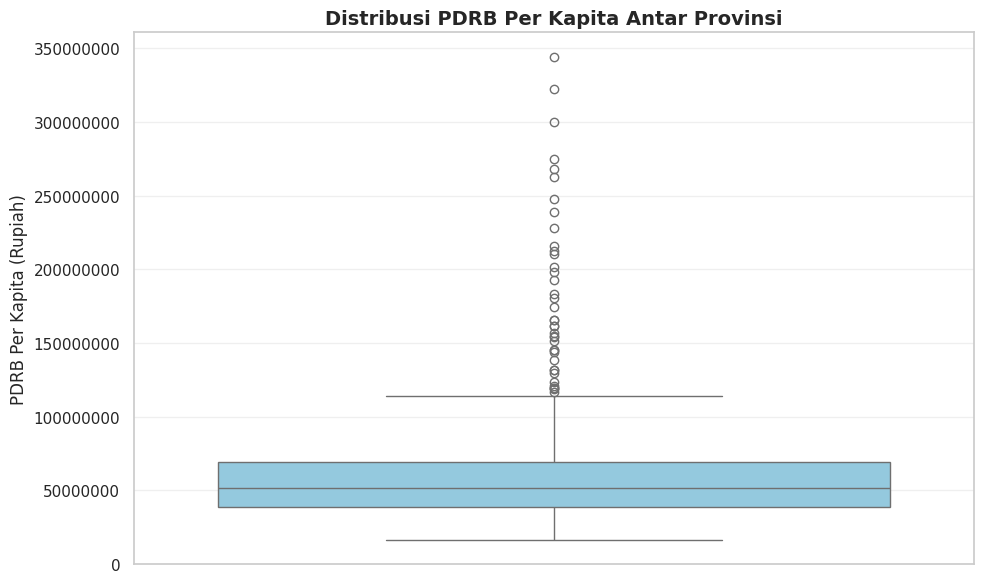

In [ ]:
# Boxplot - Distribusi PDRB
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pdrb_clean, y='PDRB_per_kapita_Rupiah', color='skyblue')
plt.title("Distribusi PDRB Per Kapita Antar Provinsi", fontsize=14, fontweight='bold')
plt.ylabel("PDRB Per Kapita (Rupiah)")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi PDRB Per Kapita Antar Provinsi
*   Sebaran Tidak Merata: Grafik boxplot menunjukkan bahwa sebagian besar provinsi memiliki PDRB per kapita yang relatif rendah dan berkumpul di kisaran bawah, sedangkan hanya beberapa provinsi yang memiliki nilai sangat tinggi.
*   Banyak Outlier: Terdapat banyak titik outlier di atas whisker, menandakan adanya provinsi-provinsi dengan PDRB per kapita jauh di atas rata-rata nasional.
*   Kesenjangan Ekonomi: Perbedaan yang signifikan antara provinsi dengan PDRB tinggi dan rendah mengindikasikan adanya kesenjangan ekonomi antarwilayah.
*   Kesimpulan: Secara umum, distribusi PDRB per kapita antar provinsi di Indonesia bersifat tidak merata, di mana hanya sedikit provinsi yang mendominasi kontribusi ekonomi nasional.



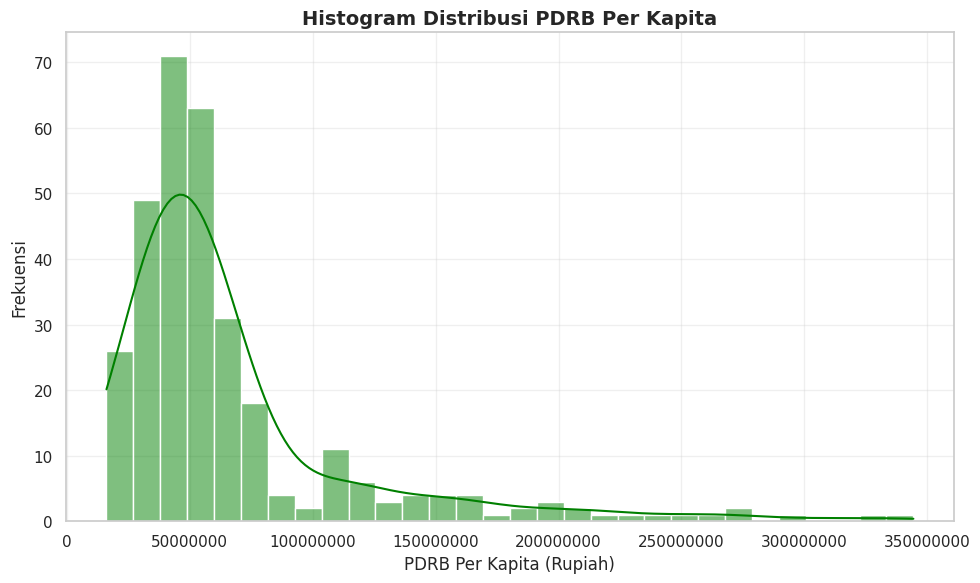

In [ ]:
# Histogram - Sebaran PDRB
plt.figure(figsize=(10, 6))
sns.histplot(df_pdrb_clean['PDRB_per_kapita_Rupiah'], bins=30, kde=True, color='green')
plt.title("Histogram Distribusi PDRB Per Kapita", fontsize=14, fontweight='bold')
plt.xlabel("PDRB Per Kapita (Rupiah)")
plt.ylabel("Frekuensi")
plt.ticklabel_format(style='plain', axis='x')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Histogram Distribusi PDRB Per Kapita
*   Sebaran Tidak Merata: Histogram menunjukkan distribusi yang condong ke kiri (right-skewed), artinya sebagian besar provinsi memiliki PDRB per kapita rendah.
*  Mayoritas di Kisaran Rendah: Frekuensi tertinggi berada di sekitar 40–60 juta rupiah per kapita, yang menandakan sebagian besar provinsi masih memiliki tingkat ekonomi menengah ke bawah.
*  Sedikit Provinsi Kaya: Hanya sedikit provinsi yang memiliki PDRB per kapita sangat tinggi, terlihat dari ekor panjang di sisi kanan grafik.
*   Kesimpulan: Distribusi ini menegaskan adanya ketimpangan ekonomi antarprovinsi di Indonesia, dengan dominasi provinsi berpendapatan rendah dan hanya sedikit daerah berpendapatan tinggi.



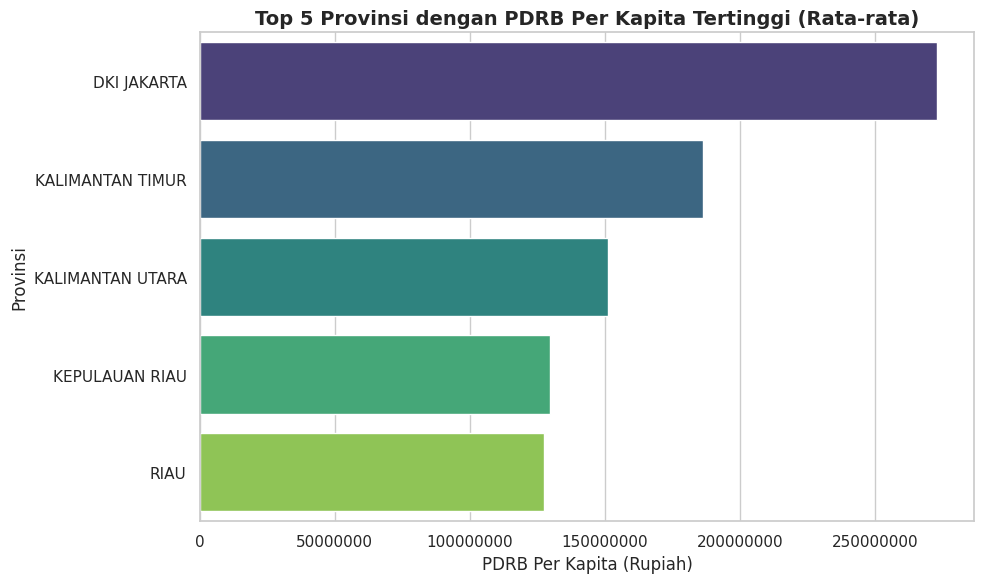

In [ ]:
# Pertanyaan 1: Top 5 Provinsi dengan PDRB tertinggi
top_pdrb = df_pdrb_clean.groupby('Provinsi')['PDRB_per_kapita_Rupiah'].mean().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_pdrb.values, y=top_pdrb.index, palette='viridis')
plt.title("Top 5 Provinsi dengan PDRB Per Kapita Tertinggi (Rata-rata)", fontsize=14, fontweight='bold')
plt.xlabel("PDRB Per Kapita (Rupiah)")
plt.ylabel("Provinsi")
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()

**INSIGHT** : Top 5 Provinsi dengan PDRB Per Kapita Tertinggi (Rata-rata) :


*   PDRB Tertinggi: DKI Jakarta memimpin jauh dengan PDRB Per Kapita sekitar Rp 27 Miliar.
*   Peringkat Kedua: Kalimantan Timur berada di urutan kedua dengan sekitar Rp 19 Miliar.
*   Tiga Provinsi Kalimantan/Riau: Tiga provinsi (Kalimantan Utara, Kepulauan Riau, dan Riau) memiliki nilai yang rapat, berkisar antara Rp 13 Miliar hingga Rp 15 Miliar.
*   Kesenjangan: Terdapat kesenjangan nilai yang signifikan antara DKI Jakarta dan provinsi-provinsi lainnya.







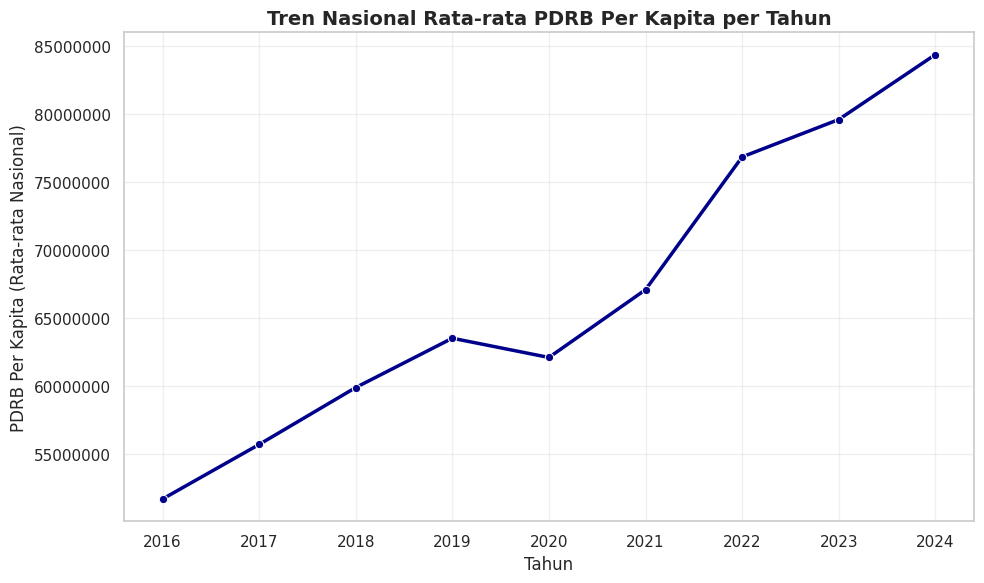

In [ ]:
# Pertanyaan 2: Tren nasional
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pdrb_clean, x='Tahun', y='PDRB_per_kapita_Rupiah', estimator='mean', ci=None, marker='o', linewidth=2.5, color='darkblue')
plt.title("Tren Nasional Rata-rata PDRB Per Kapita per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("PDRB Per Kapita (Rata-rata Nasional)")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT**:Tren Nasional Rata-rata PDRB Per Kapita per Tahun


*   Kenaikan Konsisten : Secara umum, PDRB per kapita nasional menunjukkan tren meningkat dari tahun 2016 hingga 2024.
*   Penurunan Sementara di 2020: Terlihat ada sedikit penurunan pada tahun 2020, yang kemungkinan besar disebabkan oleh dampak pandemi COVID-19 terhadap aktivitas ekonomi nasional.
*  Pemulihan dan Lonjakan Pasca-2021: Setelah tahun 2020, PDRB per kapita kembali meningkat tajam terutama pada tahun 2022, menunjukkan adanya pemulihan ekonomi yang kuat.
*  Rekor Tertinggi di 2024: Nilai rata-rata PDRB per kapita mencapai titik tertinggi pada tahun 2024, menandakan pertumbuhan ekonomi nasional yang semakin stabil dan positif.
*  Tren Jangka Panjang Positif: Meskipun sempat mengalami fluktuasi kecil, arah jangka panjang menunjukkan pertumbuhan ekonomi nasional yang berkelanjutan dari tahun ke tahun.



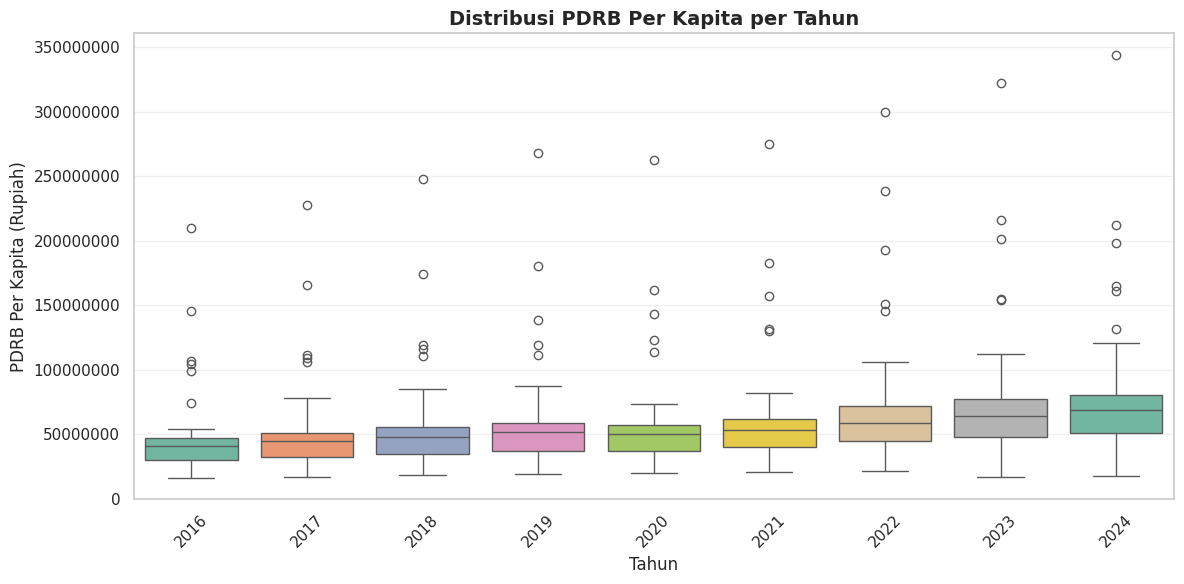

In [ ]:
# Pertanyaan 3: Distribusi per tahun (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pdrb_clean, x='Tahun', y='PDRB_per_kapita_Rupiah', palette='Set2')
plt.title("Distribusi PDRB Per Kapita per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("PDRB Per Kapita (Rupiah)")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

***INSIGHT***: Distribusi PDRB Per Kapita per Tahun
*   Kenaikan Umum: Dari tahun 2016 hingga 2024, PDRB per kapita menunjukkan tren meningkat secara keseluruhan.
*  Sebaran Melebar: Mulai 2021 hingga 2024, rentang nilai makin besar, menandakan perbedaan antar daerah semakin lebar.
*   Nilai Ekstrem: Hampir setiap tahun terdapat outlier, terutama pada 2022–2024, yang menunjukkan adanya daerah dengan nilai PDRB jauh di atas rata-rata.
* Stabil di Tengah: Nilai tengah (median) meningkat perlahan dari 2016 ke 2024, menunjukkan pertumbuhan yang konsisten.












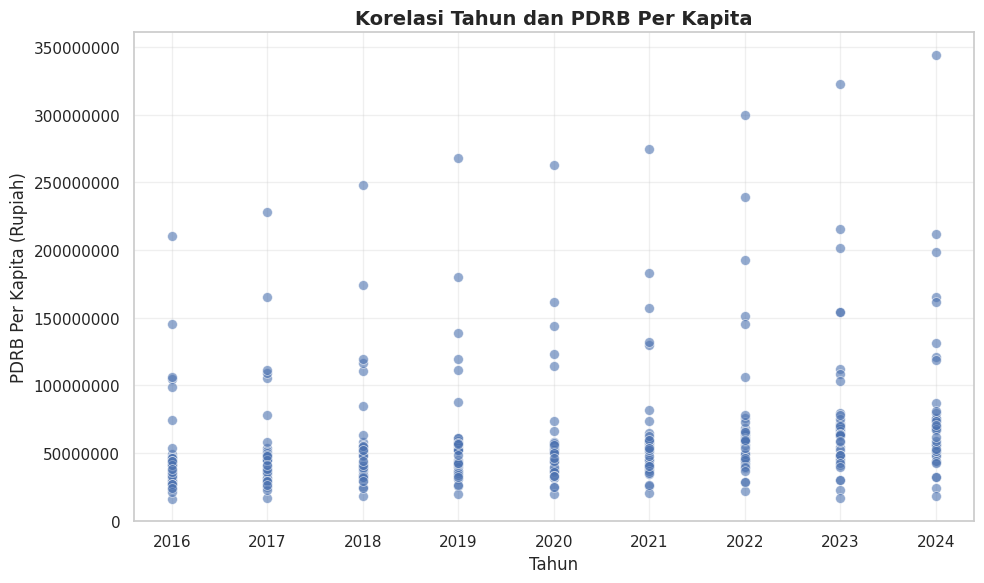

In [ ]:
# Pertanyaan 4: Scatter plot korelasi Tahun vs PDRB
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pdrb_clean, x='Tahun', y='PDRB_per_kapita_Rupiah', alpha=0.6, s=50)
plt.title("Korelasi Tahun dan PDRB Per Kapita", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("PDRB Per Kapita (Rupiah)")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT**: Korelasi Tahun dan PDRB Per Kapita
*  Korelasi Positif: Terlihat adanya hubungan positif antara tahun dan PDRB per kapita — semakin baru tahunnya, semakin tinggi nilai PDRB per kapita.
*  Tren Meningkat: Dari 2016 hingga 2024, titik-titik data cenderung bergeser ke atas, menandakan pertumbuhan ekonomi secara bertahap.
*   Fluktuasi Kecil: Meskipun ada variasi antar tahun, arah umumnya tetap naik.
*   Kenaikan Jelas Setelah 2021: Mulai tahun 2021 hingga 2024, peningkatan nilai PDRB per kapita semakin terlihat signifikan.
*   Kesimpulan: Terdapat korelasi positif yang kuat antara tahun dan PDRB per kapita, menandakan pertumbuhan ekonomi nasional yang konsisten dari waktu ke waktu.


## **2.2 EDA Dataset Timbulan Sampah**

# **Hipotesis & Pertanyaan Eksplorasi:**


1.   H1: Provinsi dengan populasi besar menghasilkan sampah lebih banyak
2.   H2: Timbulan sampah meningkat seiring waktu
3.   H3: Ada korelasi kuat antara timbulan harian dan tahunan
4.   H4: Beberapa provinsi berkontribusi dominan terhadap total sampah nasional


📋 4 Pertanyaan Eksplorasi Timbulan Sampah:

1.   Provinsi mana dengan timbulan sampah tahunan terbesar?
2.   Apakah ada tren kenaikan timbulan sampah dari tahun ke tahun?
3.   Apakah terdapat korelasi kuat antara timbulan harian dan tahunan?
4.   Bagaimana proporsi kontribusi sampah dari provinsi-provinsi teratas?

In [ ]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif Timbulan Sampah:")
print(df_waste_clean[['Timbulan_Harian_ton', 'Timbulan_Tahunan_ton', 'Tahun']].describe())


📈 Statistik Deskriptif Timbulan Sampah:
       Timbulan_Harian_ton  Timbulan_Tahunan_ton        Tahun
count          1740.000000          1.740000e+03       1740.0
mean            314.649626          1.148471e+05  2021.789655
std             390.561714          1.425550e+05     1.670881
min              11.350000          4.143330e+03       2018.0
25%              86.445000          3.155219e+04       2020.0
50%             161.985000          5.912573e+04       2022.0
75%             387.592500          1.414710e+05       2023.0
max            2813.510000          1.026931e+06       2024.0


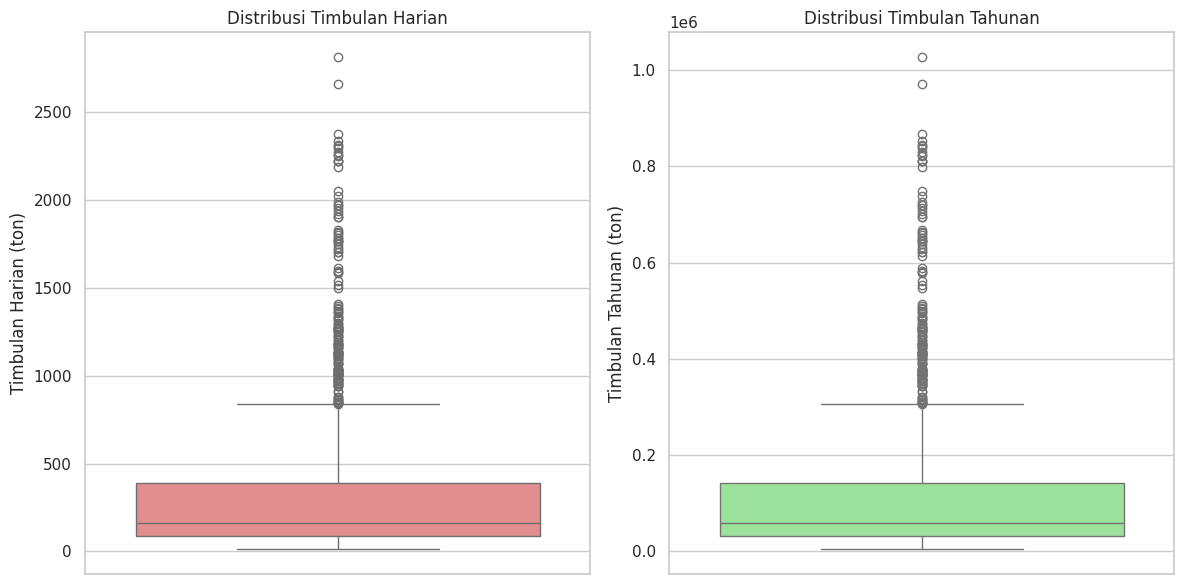

In [ ]:
# Boxplot - Distribusi Timbulan Sampah
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_waste_clean, y='Timbulan_Harian_ton', color='lightcoral')
plt.title("Distribusi Timbulan Harian")
plt.ylabel("Timbulan Harian (ton)")
plt.subplot(1, 2, 2)
sns.boxplot(data=df_waste_clean, y='Timbulan_Tahunan_ton', color='lightgreen')
plt.title("Distribusi Timbulan Tahunan")
plt.ylabel("Timbulan Tahunan (ton)")
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Timbulan Harian dan Tahunan

*   Sebaran Tidak Merata: Kedua grafik menunjukkan distribusi yang miring ke atas, dengan sebagian besar data berada di nilai rendah dan beberapa outlier di nilai sangat tinggi.
*   Banyak Outlier: Terdapat banyak titik ekstrem (outlier) di bagian atas, menandakan ada beberapa provinsi dengan timbulan sampah jauh lebih besar dari rata-rata nasional.
*   Pola Konsisten: Pola antara timbulan harian dan tahunan terlihat serupa — provinsi dengan timbulan harian besar juga menghasilkan timbulan tahunan yang besar.
*   Kesimpulan: Mayoritas provinsi memiliki volume sampah rendah hingga sedang, namun ada beberapa provinsi dengan volume sampah jauh lebih tinggi yang sangat memengaruhi total nasional.



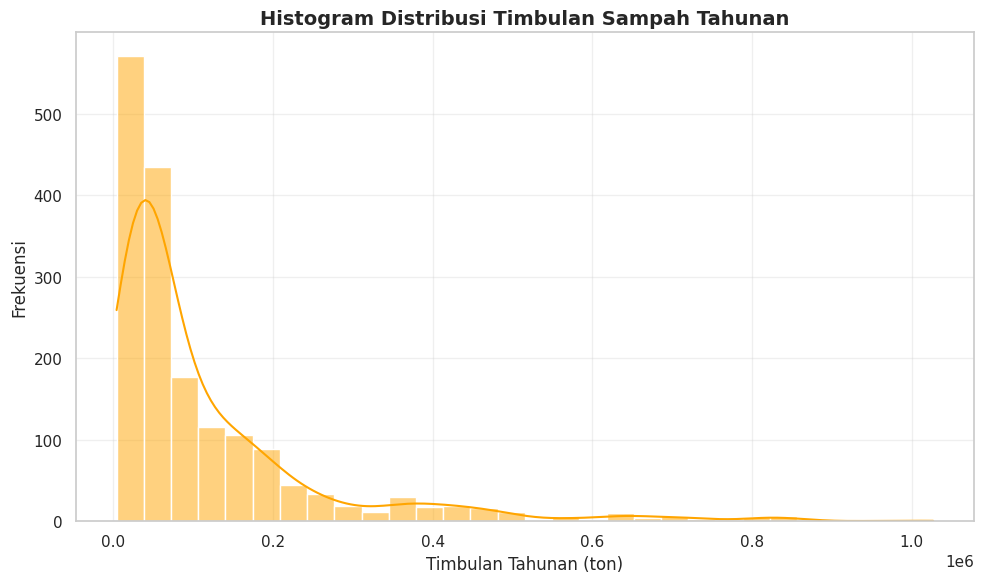

In [ ]:
# Histogram - Sebaran Timbulan
plt.figure(figsize=(10, 6))
sns.histplot(df_waste_clean['Timbulan_Tahunan_ton'], bins=30, kde=True, color='orange')
plt.title("Histogram Distribusi Timbulan Sampah Tahunan", fontsize=14, fontweight='bold')
plt.xlabel("Timbulan Tahunan (ton)")
plt.ylabel("Frekuensi")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Timbulan Sampah Tahunan
*   Grafik menunjukkan distribusi yang miring ke kanan, di mana sebagian besar wilayah memiliki timbulan sampah tahunan rendah, sedangkan hanya sedikit wilayah yang menghasilkan volume sangat tinggi.
*   Frekuensi tertinggi berada pada kisaran 0–100.000 ton per tahun, menunjukkan mayoritas wilayah memiliki timbulan sampah relatif kecil.
*   Terlihat adanya beberapa wilayah dengan timbulan di atas 400.000–1.000.000 ton per tahun, menandakan adanya daerah dengan aktivitas ekonomi dan populasi yang jauh lebih padat.
*   Perbedaan ekstrem antara wilayah berproduksi rendah dan tinggi menunjukkan bahwa timbulan sampah nasional sangat dipengaruhi oleh beberapa provinsi besar.
*   Kesimpulan: Distribusi ini menggambarkan bahwa sebagian besar daerah berkontribusi kecil terhadap total timbulan sampah, sementara hanya segelintir wilayah yang menyumbang porsi terbesar terhadap total timbulan tahunan nasional.



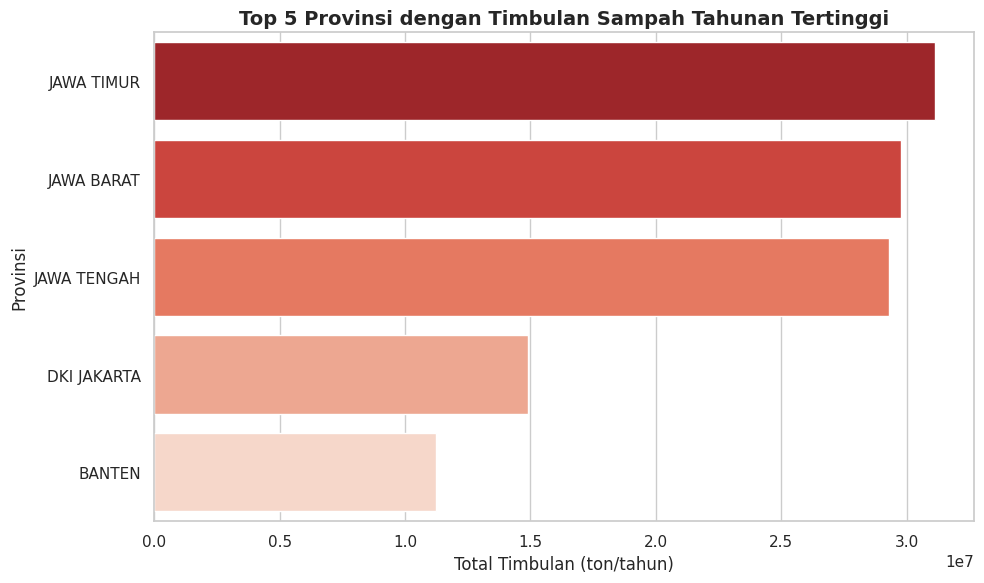

In [ ]:
# Pertanyaan 1: Top 5 provinsi dengan total sampah tahunan tertinggi
top_waste = df_waste_clean.groupby('Provinsi')['Timbulan_Tahunan_ton'].sum().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_waste.values, y=top_waste.index, palette='Reds_r')
plt.title("Top 5 Provinsi dengan Timbulan Sampah Tahunan Tertinggi", fontsize=14, fontweight='bold')
plt.xlabel("Total Timbulan (ton/tahun)")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()

**INSIGHT:** Provinsi dengan Timbulan Sampah Tahunan Tertinggi
*   Timbulan Tertinggi: Provinsi Jawa Timur memiliki timbulan sampah tahunan terbesar, mencapai lebih dari 31 juta ton per tahun.
*   Posisi Berikutnya: Disusul oleh Jawa Barat dan Jawa Tengah, masing-masing dengan total timbulan sekitar 29–30 juta ton per tahun.
*   DKI Jakarta dan Banten: Dua provinsi ini menempati posisi keempat dan kelima, dengan timbulan lebih rendah namun tetap signifikan.
*   Kesimpulan: Provinsi di Pulau Jawa mendominasi daftar timbulan sampah tertinggi, sejalan dengan tingginya jumlah penduduk dan aktivitas ekonomi di wilayah tersebut.




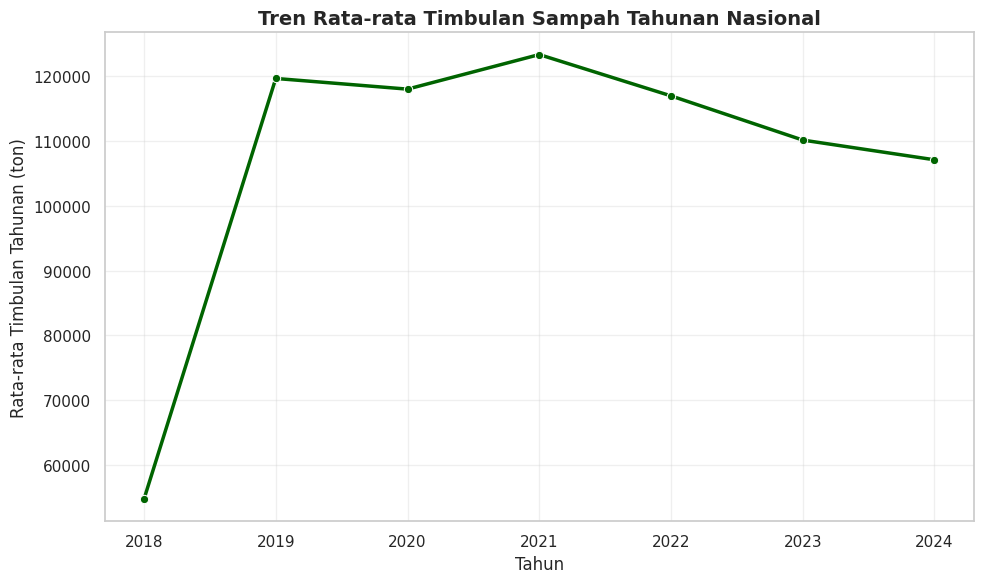

In [ ]:
# Pertanyaan 2: Tren rata-rata timbulan tahunan nasional
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_waste_clean, x='Tahun', y='Timbulan_Tahunan_ton', estimator='mean', ci=None, marker='o', linewidth=2.5, color='darkgreen')
plt.title("Tren Rata-rata Timbulan Sampah Tahunan Nasional", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("Rata-rata Timbulan Tahunan (ton)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Tren Rata-rata Timbulan Sampah Tahunan Nasional
*   Kenaikan Awal: Timbulan sampah nasional meningkat tajam dari 2018 ke 2019, menunjukkan pertumbuhan signifikan di awal periode.
*   Puncak di 2021: Nilai tertinggi terjadi pada tahun 2021, menandakan puncak produksi sampah nasional.
*  Penurunan Setelahnya: Setelah 2021, tren menunjukkan penurunan bertahap hingga tahun 2024.
*   Kesimpulan: Tidak ada tren kenaikan terus-menerus — timbulan sampah naik di awal periode, lalu menurun stabil setelah 2021.



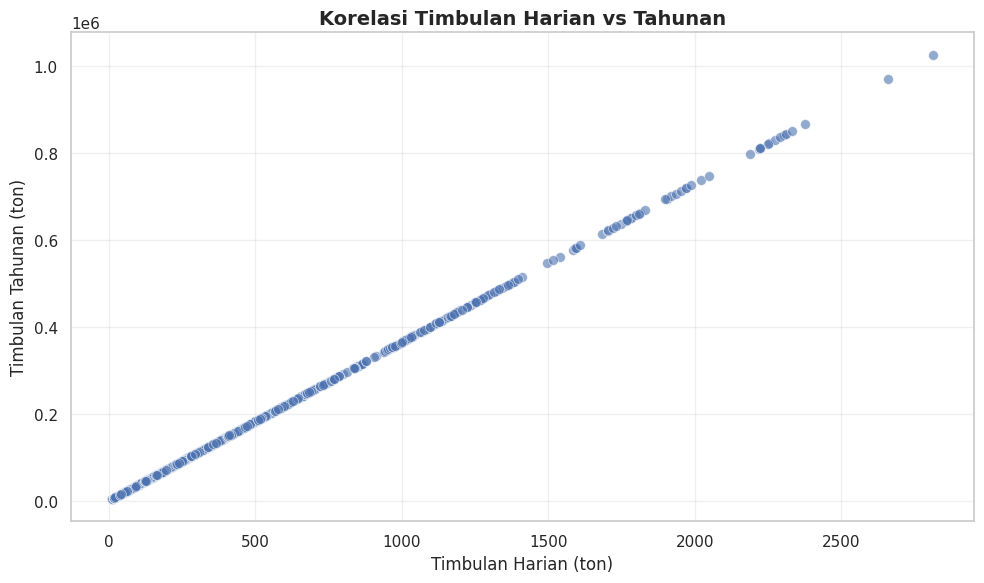

In [ ]:
# Pertanyaan 3: Korelasi timbulan harian vs tahunan
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_waste_clean, x='Timbulan_Harian_ton', y='Timbulan_Tahunan_ton', alpha=0.6, s=50)
plt.title("Korelasi Timbulan Harian vs Tahunan", fontsize=14, fontweight='bold')
plt.xlabel("Timbulan Harian (ton)")
plt.ylabel("Timbulan Tahunan (ton)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Korelasi Timbulan Harian vs Tahunan
*   Korelasi Sangat Kuat: Grafik menunjukkan hubungan linear sempurna antara timbulan harian dan tahunan — semakin besar timbulan harian suatu provinsi, semakin besar pula kontribusinya secara tahunan.
*   Provinsi Besar Dominan: Provinsi dengan aktivitas ekonomi dan jumlah penduduk tinggi (seperti Jawa Timur, Jawa Barat, dan Jawa Tengah) menjadi penyumbang utama timbulan sampah nasional.
*  Kontribusi Proporsional: Karena hubungan linear, provinsi dengan timbulan harian tinggi memberikan proporsi besar terhadap total nasional, tanpa penyimpangan berarti.
*  Kesimpulan: Sebagian besar total sampah nasional berasal dari beberapa provinsi besar, yang menunjukkan bahwa upaya pengelolaan sampah sebaiknya difokuskan di wilayah padat penduduk tersebut.


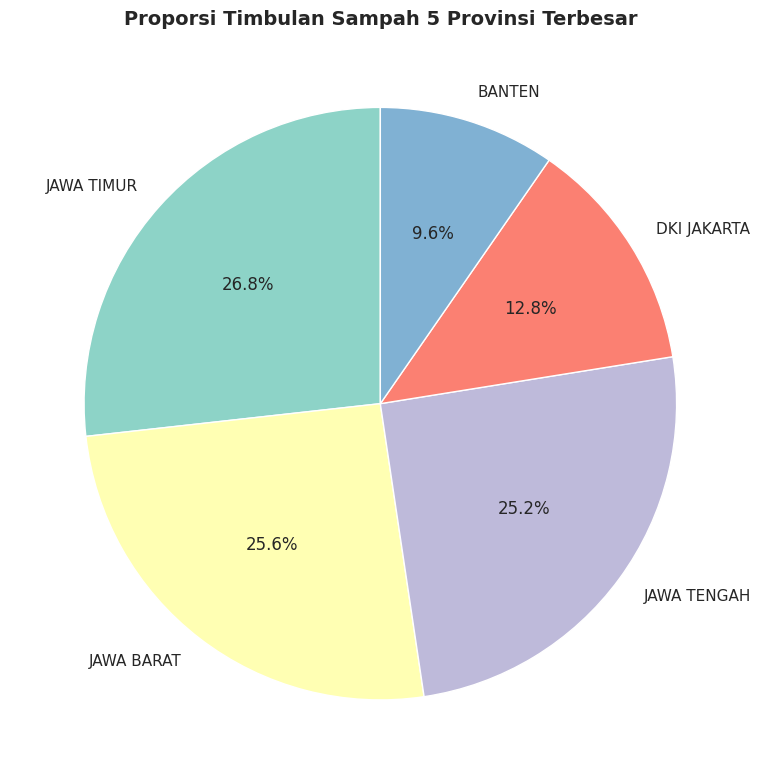

In [ ]:
# Pertanyaan 4: Pie chart proporsi
top5_waste = df_waste_clean.groupby('Provinsi')['Timbulan_Tahunan_ton'].sum().nlargest(5)
plt.figure(figsize=(8, 8))
plt.pie(top5_waste.values, labels=top5_waste.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3'))
plt.title("Proporsi Timbulan Sampah 5 Provinsi Terbesar", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**INSIGHT:** Proporsi Timbulan Sampah 5 Provinsi Terbesar
*   Dominasi Pulau Jawa: Tiga provinsi di Pulau Jawa — Jawa Timur (26,8%), Jawa Barat (25,6%), dan Jawa Tengah (25,2%) — menyumbang hampir tiga perempat dari total timbulan sampah nasional. Hal ini menunjukkan bahwa Pulau Jawa merupakan pusat utama penghasil sampah di Indonesia.
*   Kepadatan Penduduk dan Aktivitas Ekonomi: DKI Jakarta (12,8%) memiliki kontribusi besar meskipun wilayahnya kecil, disebabkan oleh tingginya aktivitas ekonomi dan kepadatan penduduk yang menghasilkan volume sampah tinggi per kapita.
*   Kontribusi Relatif Banten: Banten (9,6%) menjadi penyumbang terkecil di antara lima besar, namun tetap signifikan karena posisinya yang berdekatan dengan Jakarta serta berperan dalam rantai distribusi dan konsumsi wilayah Jabodetabek.
*   Fokus Pengelolaan di Pulau Jawa: Dengan lebih dari 77% total timbulan sampah berasal dari Pulau Jawa, kebijakan nasional pengelolaan sampah sebaiknya dipusatkan pada provinsi-provinsi padat penduduk ini, terutama dalam peningkatan sistem daur ulang, pengurangan sampah rumah tangga, dan edukasi masyarakat.




## **2.3 EDA Dataset Infarstruktur Sampah**

🏗️ EXPLORATORY DATA ANALYSIS - INFRASTRUKTUR SAMPAH

# **Hipotesis & Pertanyaan Eksplorasi:**


1.   H1: Provinsi dengan fasilitas banyak memiliki kapasitas pengelolaan lebih baik
2.   H2: Jumlah fasilitas meningkat seiring waktu
1.   H3: Ada kesenjangan infrastruktur antar provinsi
2.   H4: Kapasitas sampah masuk berkorelasi dengan jumlah fasilitas

📋 4 Pertanyaan Eksplorasi Infrastruktur:
1. Provinsi mana yang memiliki jumlah fasilitas pengelolaan sampah Terbanyak?
2. Bagaimana tren perkembangan jumlah fasilitas dari tahun ke tahun?
3. Bagaimana distribusi kapasitas fasilitas antar provinsi?
4. Apakah ada korelasi antara jumlah fasilitas dan kapasitas sampah masuk?

In [ ]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif Infrastruktur:")
print(df_infra_summary[['Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton', 'Tahun']].describe())


📈 Statistik Deskriptif Infrastruktur:
       Jumlah_Fasilitas  Infra_Sampahmasuk_ton        Tahun
count        181.000000           1.810000e+02        181.0
mean           9.254144           3.732276e+05  2022.022099
std            9.824660           5.897174e+05     1.505382
min            1.000000           3.168000e+02       2019.0
25%            2.000000           3.662045e+04       2021.0
50%            5.000000           1.393448e+05       2022.0
75%           14.000000           4.242619e+05       2023.0
max           49.000000           3.334616e+06       2024.0


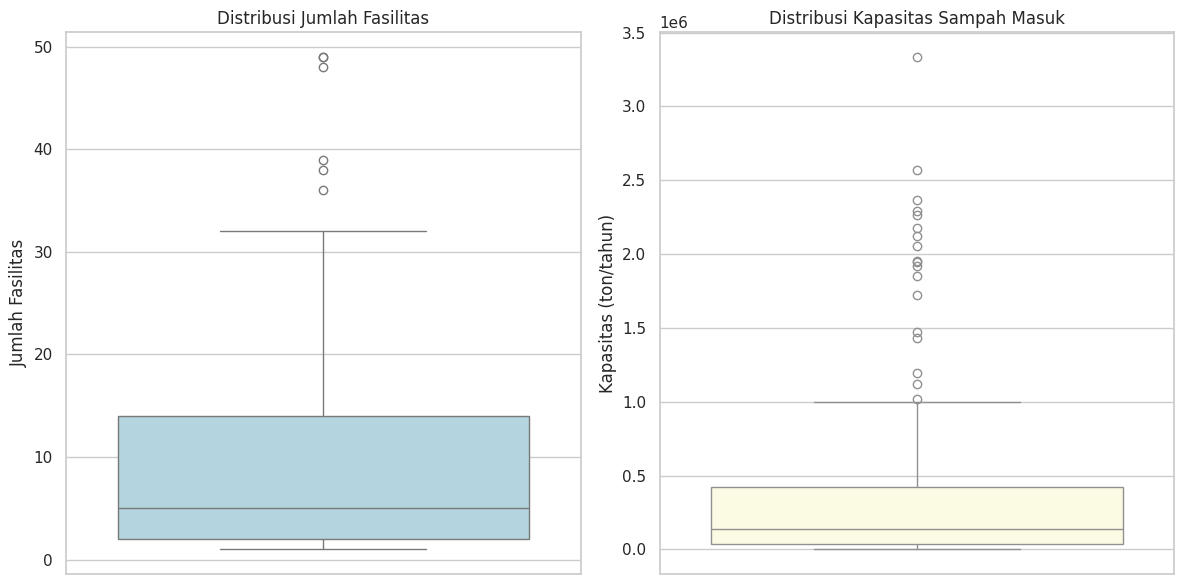

In [ ]:
# Boxplot - Distribusi Infrastruktur
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_infra_summary, y='Jumlah_Fasilitas', color='lightblue')
plt.title("Distribusi Jumlah Fasilitas")
plt.ylabel("Jumlah Fasilitas")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_infra_summary, y='Infra_Sampahmasuk_ton', color='lightyellow')
plt.title("Distribusi Kapasitas Sampah Masuk")
plt.ylabel("Kapasitas (ton/tahun)")
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Jumlah Fasilitas dan Kapasitas Sampah Masuk
*   Sebaran Tidak Merata: Kedua grafik menunjukkan distribusi yang tidak merata dengan banyak nilai rendah dan sedikit nilai ekstrem di bagian atas.
*   Jumlah Fasilitas Rendah: Sebagian besar wilayah hanya memiliki 1–10 fasilitas pengelolaan sampah, dengan median sekitar 5 fasilitas. Namun terdapat beberapa outlier hingga 48 fasilitas, menunjukkan ketimpangan ketersediaan infrastruktur antarwilayah.
*   Kapasitas Sampah Masuk Variatif: Sebagian besar wilayah memiliki kapasitas pengelolaan di bawah 500.000 ton per tahun, sementara beberapa wilayah memiliki kapasitas sangat besar hingga sekitar 3.000.000 ton per tahun.
*   Adanya Outlier Signifikan: Banyak titik ekstrem pada grafik kapasitas sampah masuk, menandakan bahwa sebagian kecil wilayah menampung volume sampah jauh lebih besar dibanding lainnya.
*   Kesimpulan: Distribusi ini mengindikasikan adanya ketimpangan dalam jumlah fasilitas dan kapasitas pengelolaan antarwilayah — sebagian besar daerah masih memiliki fasilitas terbatas, sementara hanya sedikit wilayah yang mampu menampung dan mengelola volume sampah dalam skala besar.






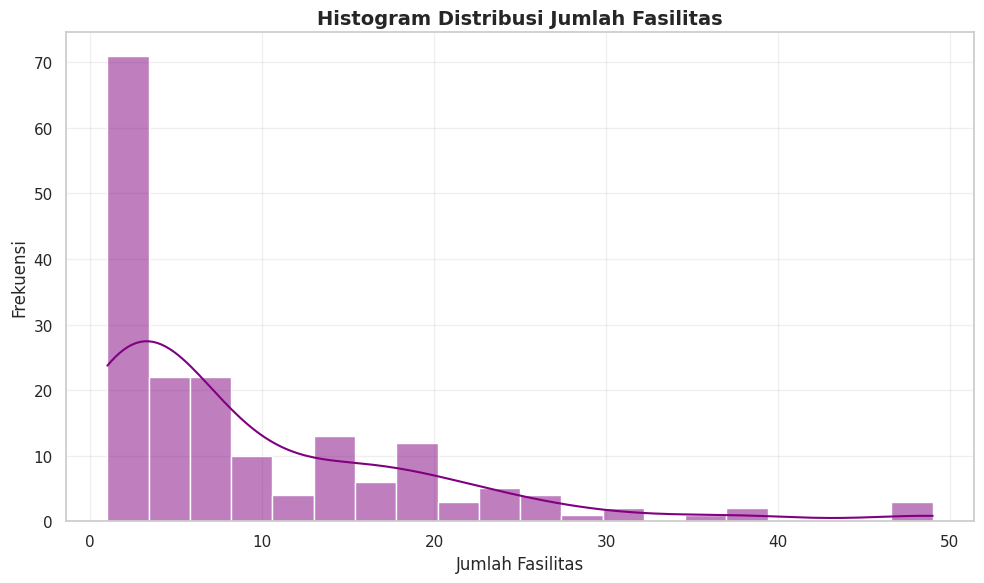

In [ ]:
# Histogram - Sebaran Fasilitas
plt.figure(figsize=(10, 6))
sns.histplot(df_infra_summary['Jumlah_Fasilitas'], bins=20, kde=True, color='purple')
plt.title("Histogram Distribusi Jumlah Fasilitas", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Fasilitas")
plt.ylabel("Frekuensi")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Jumlah Fasilitas

*   Sebaran Miring ke Kanan: Grafik menunjukkan distribusi yang sangat miring ke kanan (right-skewed), di mana sebagian besar wilayah memiliki jumlah fasilitas yang rendah.
*   Dominasi Jumlah Fasilitas Sedikit: Frekuensi tertinggi berada pada wilayah dengan 1–5 fasilitas, menandakan mayoritas daerah memiliki infrastruktur pengelolaan sampah yang terbatas.
*  Wilayah dengan Fasilitas Banyak: Hanya sedikit wilayah yang memiliki lebih dari 20 fasilitas, dan jumlah ini menurun drastis hingga maksimum sekitar 48 fasilitas.
*   Ketimpangan Infrastruktur: Pola ini menunjukkan ketimpangan penyebaran fasilitas pengelolaan sampah antarwilayah — sebagian besar daerah masih kekurangan fasilitas, sementara hanya sedikit yang memiliki jumlah memadai.
*   Kesimpulan: Diperlukan pemerataan pembangunan fasilitas pengelolaan sampah agar kapasitas penanganan lebih seimbang di seluruh wilayah.







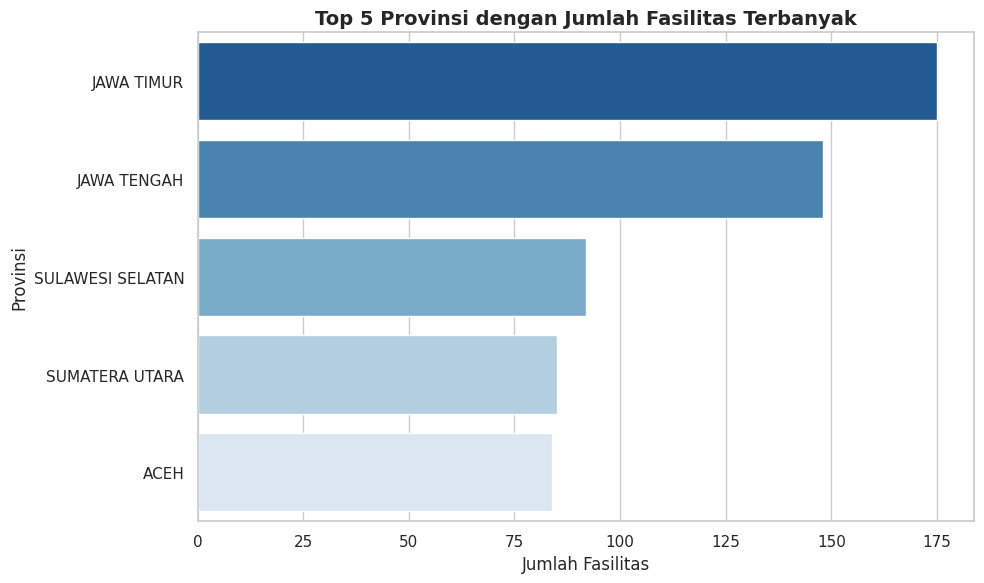

In [ ]:
# Pertanyaan 1: Top 5 provinsi dengan jumlah fasilitas terbanyak
top_infra = df_infra_summary.groupby('Provinsi')['Jumlah_Fasilitas'].sum().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_infra.values, y=top_infra.index, palette='Blues_r')
plt.title("Top 5 Provinsi dengan Jumlah Fasilitas Terbanyak", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Fasilitas")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()

**INSIGHT:** Top 5 Provinsi dengan Jumlah Fasilitas Pengelolaan Sampah Terbanyak
*  Provinsi Terkaya Fasilitas: Jawa Timur memiliki jumlah fasilitas pengelolaan sampah terbanyak, mencapai sekitar 175 fasilitas, menandakan kesiapan infrastruktur pengelolaan limbah yang lebih baik dibanding provinsi lain.
*   Dominasi Pulau Jawa: Jawa Tengah berada di posisi kedua dengan sekitar 150 fasilitas, menunjukkan bahwa Pulau Jawa memiliki perhatian tinggi terhadap pengelolaan sampah karena kepadatan penduduk dan aktivitas industrinya.
*  Sebaran di Luar Jawa: Sulawesi Selatan, Sumatera Utara, dan Aceh juga masuk lima besar, memperlihatkan pemerataan fasilitas di luar Pulau Jawa meskipun jumlahnya masih jauh lebih sedikit.
* Kesimpulan: Ketersediaan fasilitas pengelolaan sampah masih terpusat di Pulau Jawa. Pemerintah dapat memperkuat pembangunan fasilitas di provinsi luar Jawa untuk mendorong pengelolaan sampah yang lebih merata di seluruh Indonesia.





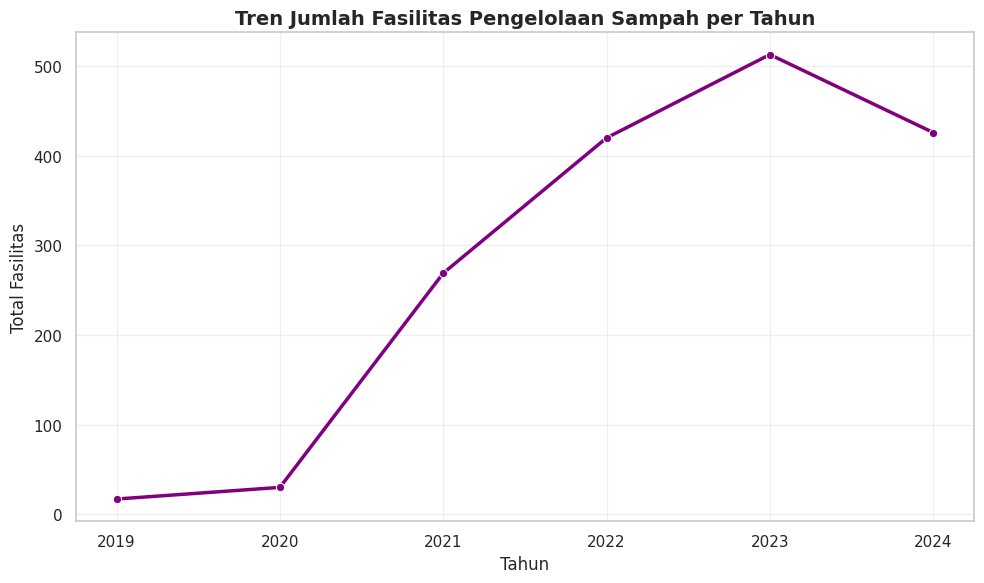

In [ ]:
# Pertanyaan 2: Tren jumlah fasilitas per tahun
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_infra_summary, x='Tahun', y='Jumlah_Fasilitas', estimator='sum', ci=None, marker='o', linewidth=2.5, color='purple')
plt.title("Tren Jumlah Fasilitas Pengelolaan Sampah per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("Total Fasilitas")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Tren Jumlah Fasilitas Pengelolaan Sampah per Tahun
*   Peningkatan Signifikan: Jumlah fasilitas pengelolaan sampah meningkat pesat dari tahun 2019 hingga 2023, menunjukkan adanya perhatian pemerintah dan daerah terhadap peningkatan infrastruktur pengelolaan limbah.
*  Pertumbuhan Tercepat: Lonjakan terbesar terjadi antara 2020 dan 2021, di mana jumlah fasilitas melonjak tajam, kemungkinan akibat program percepatan pembangunan fasilitas pengolahan sampah.
*  Penurunan di 2024: Tahun 2024 mengalami sedikit penurunan jumlah fasilitas dibandingkan 2023, yang dapat disebabkan oleh keterbatasan anggaran, perawatan fasilitas lama, atau proses evaluasi terhadap efektivitas fasilitas yang sudah ada.
*   Kesimpulan: Secara keseluruhan, tren menunjukkan perkembangan positif dalam upaya memperluas infrastruktur pengelolaan sampah di Indonesia, meskipun diperlukan upaya berkelanjutan agar peningkatan jumlah fasilitas dapat terus stabil di masa depan.





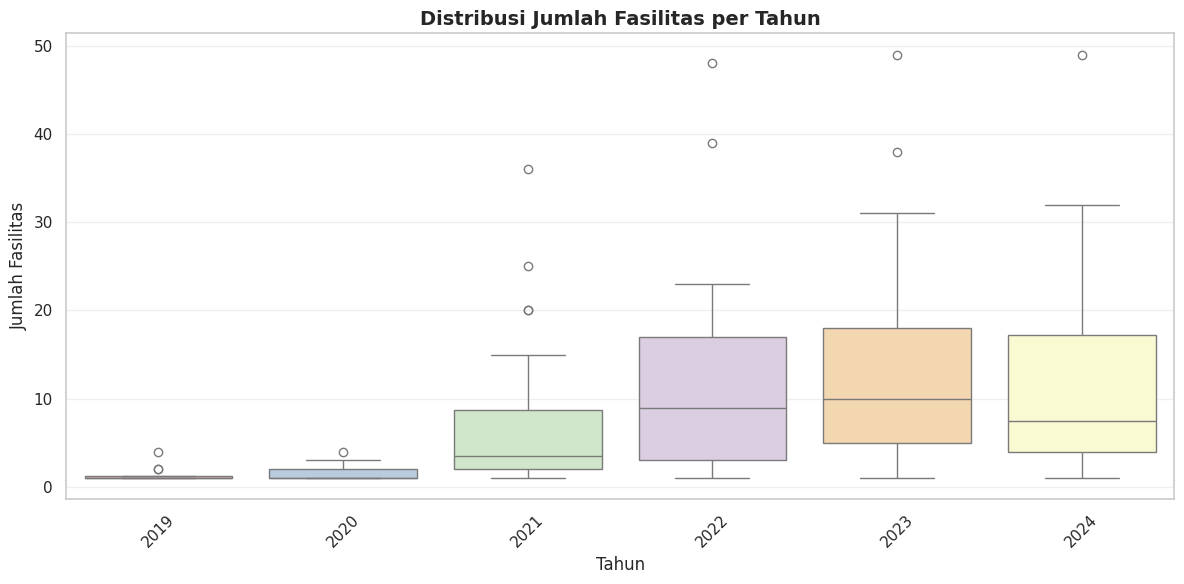

In [ ]:
# Pertanyaan 3: Distribusi per tahun (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_infra_summary, x='Tahun', y='Jumlah_Fasilitas', palette='Pastel1')
plt.title("Distribusi Jumlah Fasilitas per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("Jumlah Fasilitas")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Jumlah Fasilitas Antar Provinsi per tahun
*   Peningkatan Bertahap: Terlihat adanya peningkatan jumlah fasilitas dari tahun ke tahun. Pada 2019–2020, jumlah fasilitas masih sangat rendah, namun mulai meningkat signifikan sejak 2021 hingga 2024.
*   Peningkatan Variasi Seiring Waktu: Rentang (IQR) dan sebaran data semakin melebar setelah tahun 2021, menandakan bahwa perbedaan jumlah fasilitas antar provinsi makin besar — ada provinsi yang berkembang pesat, sementara sebagian lainnya masih tertinggal.
*  Kemunculan Outlier: Setiap tahun muncul beberapa provinsi dengan jumlah fasilitas jauh di atas rata-rata, terutama sejak 2021. Hal ini menunjukkan bahwa ada provinsi-provinsi tertentu yang menjadi pusat pengembangan fasilitas secara intensif.
*   Kestabilan Relatif 2023–2024: Meskipun median jumlah fasilitas tetap tinggi, distribusinya mulai stabil dibandingkan tahun-tahun sebelumnya, mengindikasikan pemerataan pembangunan fasilitas mulai terjadi di beberapa wilayah.




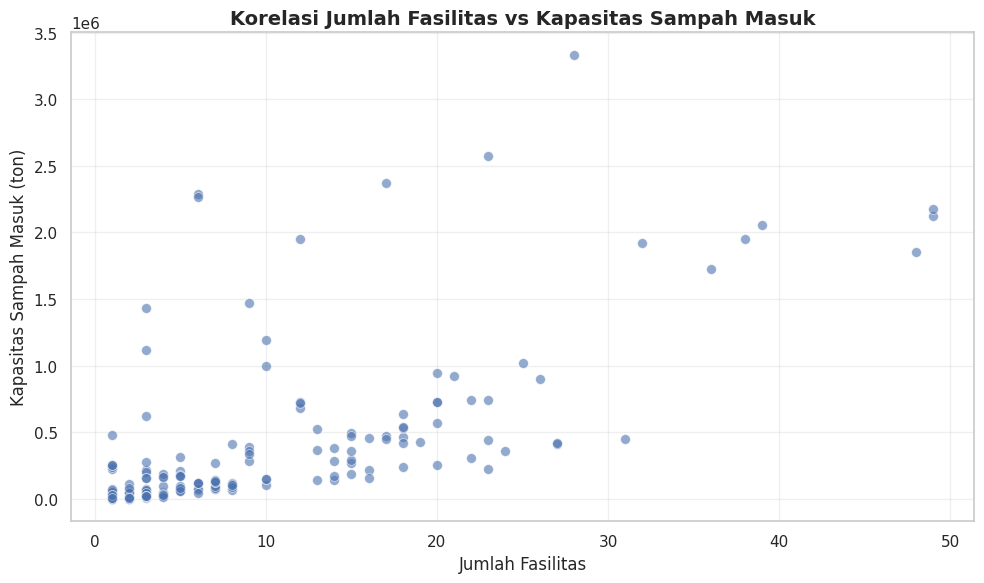

In [ ]:
# Pertanyaan 4: Scatter plot korelasi
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_infra_summary, x='Jumlah_Fasilitas', y='Infra_Sampahmasuk_ton', alpha=0.6, s=50)
plt.title("Korelasi Jumlah Fasilitas vs Kapasitas Sampah Masuk", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Fasilitas")
plt.ylabel("Kapasitas Sampah Masuk (ton)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Korelasi antara Jumlah Fasilitas dan Kapasitas Sampah Masuk
*   Arah Hubungan Positif: Secara umum, terlihat bahwa semakin banyak jumlah fasilitas yang dimiliki suatu provinsi, semakin besar pula kapasitas sampah yang dapat ditampung atau dikelola. Hal ini menunjukkan adanya korelasi positif antara kedua variabel tersebut.
*   Sebaran Data yang Variatif: Meskipun terdapat tren positif, sebaran titik yang cukup lebar pada rentang jumlah fasilitas rendah (0–20) menandakan bahwa provinsi dengan jumlah fasilitas serupa bisa memiliki kapasitas pengelolaan yang sangat berbeda, tergantung pada skala dan efisiensi fasilitasnya.
*   Outlier pada Fasilitas Besar: Beberapa provinsi dengan jumlah fasilitas tinggi (lebih dari 30) memiliki kapasitas pengelolaan sampah yang jauh lebih besar dari rata-rata, mengindikasikan adanya pusat pengolahan sampah berskala besar di wilayah tersebut.
*   Implikasi: Peningkatan jumlah fasilitas cenderung berbanding lurus dengan peningkatan kapasitas pengelolaan sampah, namun kuantitas fasilitas saja tidak cukup — kualitas, kapasitas per fasilitas, dan efisiensi operasional juga menjadi faktor penting dalam meningkatkan kemampuan pengelolaan sampah nasional.



## **2.4 EDA Dataset Penduduk**

👥 EXPLORATORY DATA ANALYSIS - POPULASI PENDUDUK

# **Hipotesis & Pertanyaan Eksplorasi:**


1.   H1: Provinsi dengan penduduk terbanyak berada di Pulau Jawa
2.   H2: Populasi nasional meningkat setiap tahun
3.   H3: Terdapat disparitas besar jumlah penduduk antar provinsi
4.   H4: Pertumbuhan penduduk relatif stabil

📋 4 Pertanyaan Eksplorasi Populasi:
1. Provinsi mana dengan jumlah penduduk terbanyak?
2. Bagaimana tren pertumbuhan penduduk nasional dari tahun ke tahun?
3. Bagaimana distribusi jumlah penduduk antar provinsi?
4. Provinsi mana yang mengalami pertumbuhan penduduk tertinggi?

In [ ]:
# Statistik deskriptif
print("\n📈 Statistik Deskriptif Populasi:")
print(df_pop_clean[['Jumlah_Penduduk', 'Tahun']].describe())


📈 Statistik Deskriptif Populasi:
       Jumlah_Penduduk        Tahun
count     1.350000e+02        135.0
mean      8.041290e+06  2022.511111
std       1.138918e+07     1.118812
min       7.018000e+05       2021.0
25%       2.116850e+06       2022.0
50%       4.273400e+06       2023.0
75%       7.597750e+06       2023.5
max       5.034520e+07       2024.0


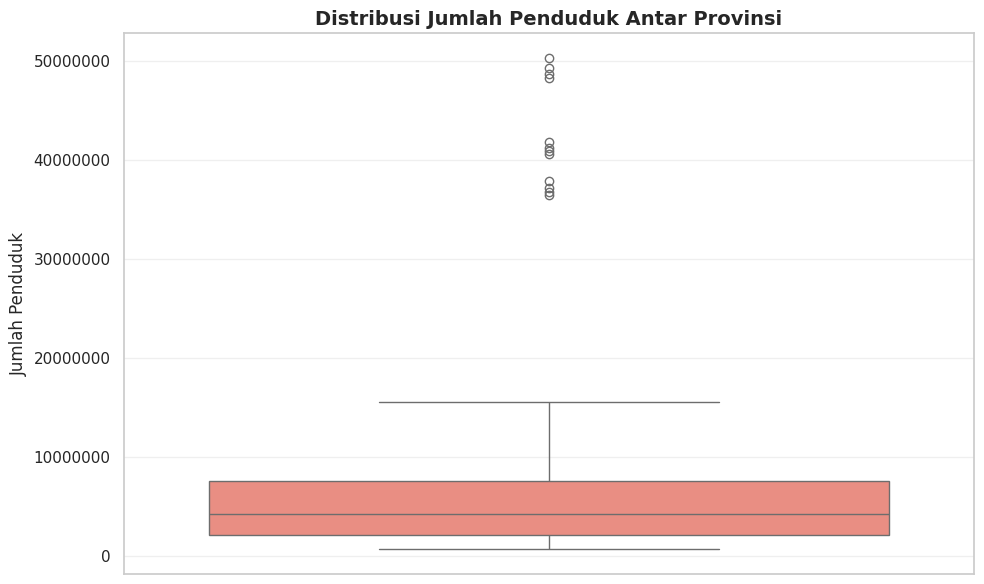

In [ ]:
# Boxplot - Distribusi Penduduk
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pop_clean, y='Jumlah_Penduduk', color='salmon')
plt.title("Distribusi Jumlah Penduduk Antar Provinsi", fontsize=14, fontweight='bold')
plt.ylabel("Jumlah Penduduk")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Jumlah Penduduk Antar Provinsi


*   Sebaran Tidak Merata: Grafik menunjukkan distribusi jumlah penduduk antar provinsi yang sangat tidak merata, dengan mayoritas provinsi memiliki jumlah penduduk di bawah 10 juta jiwa.
*   Banyak Outlier: Terdapat beberapa outlier di atas 30 juta hingga 50 juta jiwa, yang kemungkinan berasal dari provinsi dengan populasi padat seperti Jawa Barat, Jawa Timur, atau Jawa Tengah.
*  Median Penduduk: Nilai tengah (median) berada di kisaran 4–5 juta jiwa, menandakan separuh provinsi memiliki jumlah penduduk di bawah angka tersebut.
*   Ketimpangan Kepadatan: Adanya beberapa provinsi dengan jumlah penduduk jauh di atas rata-rata menunjukkan konsentrasi penduduk tinggi di wilayah tertentu, sementara sebagian besar provinsi berpenduduk relatif sedikit.
*   Kesimpulan: Distribusi ini mengindikasikan adanya ketimpangan demografis antarprovinsi, yang dapat memengaruhi kebutuhan infrastruktur, layanan publik, dan pengelolaan sumber daya secara regional.






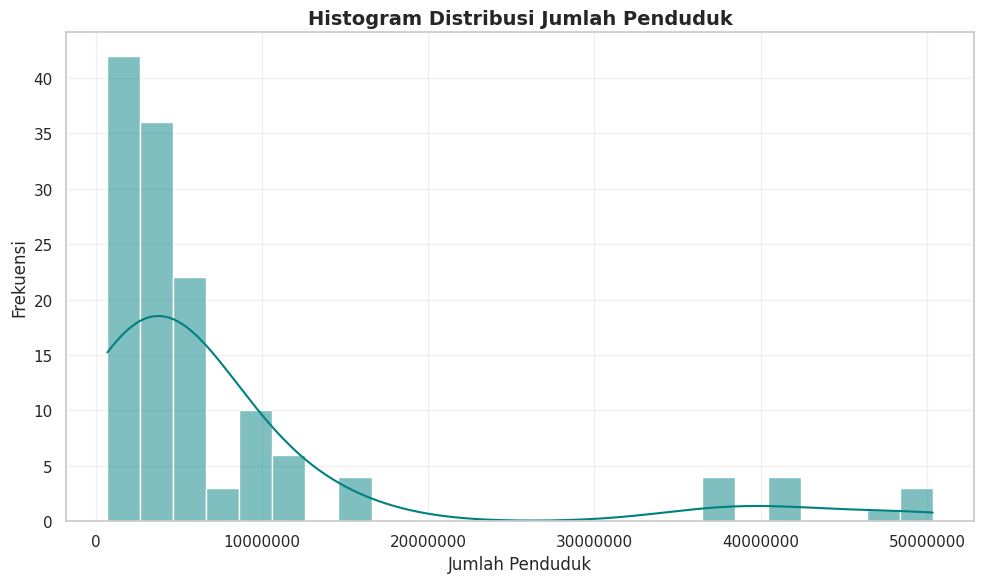

In [ ]:
# Histogram - Sebaran Penduduk
plt.figure(figsize=(10, 6))
sns.histplot(df_pop_clean['Jumlah_Penduduk'], bins=25, kde=True, color='teal')
plt.title("Histogram Distribusi Jumlah Penduduk", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Penduduk")
plt.ylabel("Frekuensi")
plt.ticklabel_format(style='plain', axis='x')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Histogram Distribusi Jumlah Penduduk
*   Sebaran Condong ke Kiri (Right-Skewed): Histogram menunjukkan bahwa sebagian besar provinsi memiliki jumlah penduduk rendah, dengan frekuensi tertinggi berada di kisaran 0–10 juta jiwa.
*   Sedikit Provinsi dengan Populasi Besar: Frekuensi menurun drastis seiring bertambahnya jumlah penduduk, menandakan hanya beberapa provinsi yang memiliki populasi sangat besar (di atas 30 juta jiwa).
*   Dominasi Provinsi Berpenduduk Sedikit: Lebih dari 60% provinsi memiliki jumlah penduduk di bawah 10 juta jiwa, menunjukkan ketimpangan kepadatan antarwilayah.
*   Outlier Populasi Tinggi: Beberapa titik di sisi kanan grafik mencerminkan provinsi padat seperti Jawa Barat, Jawa Timur, dan Jawa Tengah, yang memiliki penduduk hingga 50 juta jiwa.
*   Kesimpulan: Distribusi ini menegaskan bahwa populasi Indonesia terkonsentrasi di sedikit provinsi, sementara sebagian besar wilayah memiliki populasi relatif kecil, yang berdampak pada ketimpangan pembangunan dan kebutuhan sumber daya regional.







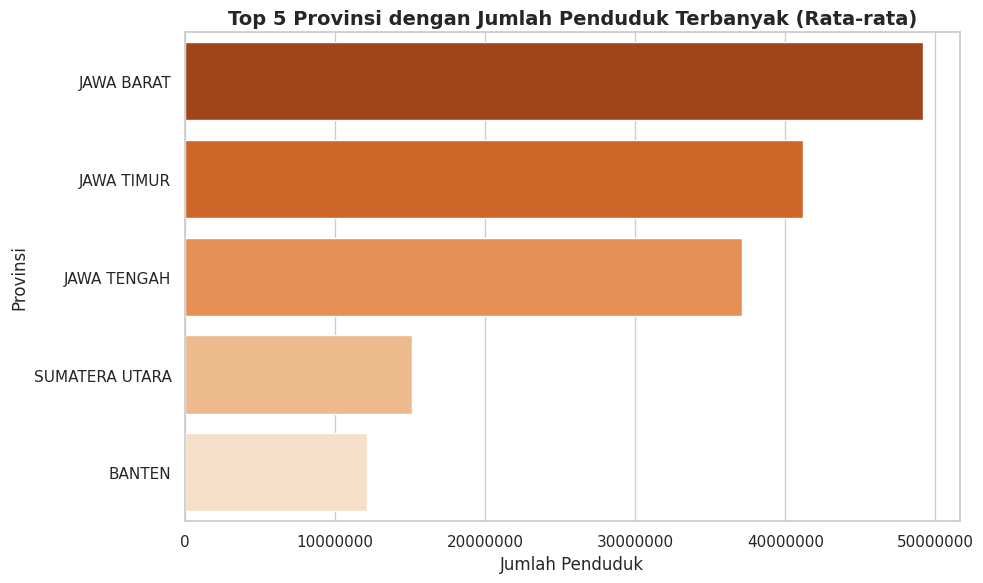

In [ ]:
# Pertanyaan 1: Top 5 provinsi dengan jumlah penduduk terbanyak
top_pop = df_pop_clean.groupby('Provinsi')['Jumlah_Penduduk'].mean().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_pop.values, y=top_pop.index, palette='Oranges_r')
plt.title("Top 5 Provinsi dengan Jumlah Penduduk Terbanyak (Rata-rata)", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Penduduk")
plt.ylabel("Provinsi")
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()

**INSIGHT:** Top 5 Provinsi dengan Jumlah Penduduk Terbanyak
*  Jawa Barat sebagai Provinsi Terpadat: Jawa Barat menempati posisi teratas dengan jumlah penduduk rata-rata tertinggi, mencapai hampir 50 juta jiwa. Hal ini menjadikannya provinsi dengan populasi terbesar di Indonesia.
*   Dominasi Pulau Jawa: Empat dari lima provinsi dengan jumlah penduduk terbanyak berasal dari Pulau Jawa — yaitu Jawa Barat, Jawa Timur, Jawa Tengah, dan Banten — yang menunjukkan bahwa Pulau Jawa masih menjadi pusat konsentrasi penduduk nasional.
*  Posisi Sumatera Utara: Sumatera Utara menjadi satu-satunya provinsi di luar Pulau Jawa yang masuk dalam daftar lima besar, menandakan tingginya aktivitas dan kepadatan penduduk di wilayah barat Indonesia.
*   LImplikasi Kepadatan: Konsentrasi penduduk yang tinggi di Pulau Jawa memiliki implikasi besar terhadap kebutuhan infrastruktur, pengelolaan sampah, serta penyediaan layanan publik yang lebih kompleks dibandingkan wilayah lain.




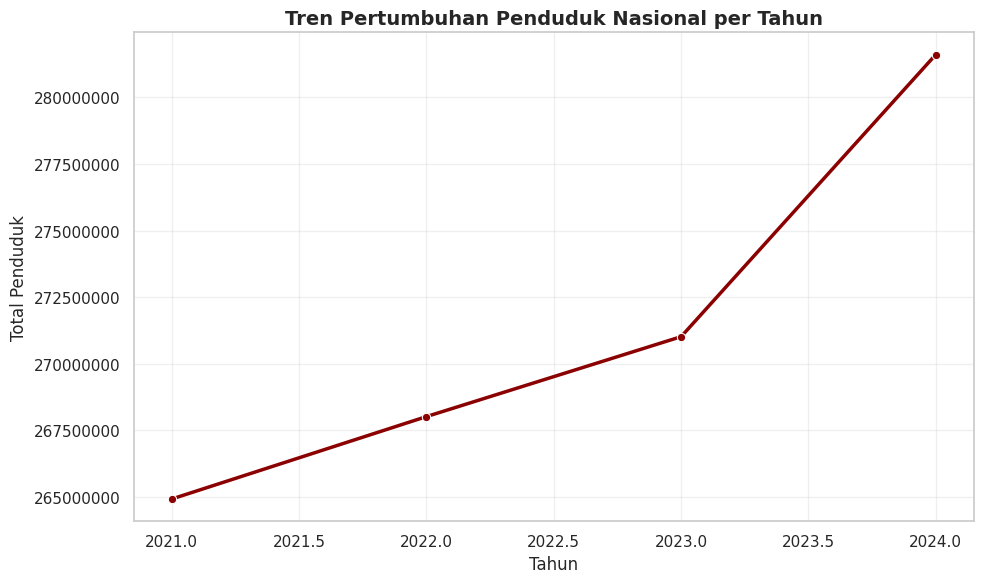

In [ ]:
# Pertanyaan 2: Tren pertumbuhan penduduk nasional per tahun
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pop_clean, x='Tahun', y='Jumlah_Penduduk', estimator='sum', ci=None, marker='o', linewidth=2.5, color='darkred')
plt.title("Tren Pertumbuhan Penduduk Nasional per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("Total Penduduk")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Tren Pertumbuhan Penduduk Nasional per Tahun
*   Pertumbuhan Konsisten: Jumlah penduduk Indonesia menunjukkan tren peningkatan yang konsisten dari tahun 2021 hingga 2024, tanpa adanya penurunan pada periode tersebut.
*  Kenaikan Signifikan di 2024: Lonjakan paling tajam terjadi pada tahun 2024, di mana total penduduk meningkat jauh dibandingkan tahun-tahun sebelumnya. Hal ini mengindikasikan adanya pertumbuhan populasi yang semakin cepat pada periode terbaru.
*   Stabilitas Sebelum 2024: Dari tahun 2021 hingga 2023, pertumbuhan cenderung stabil dengan kenaikan moderat setiap tahunnya, mencerminkan pertambahan alami penduduk yang relatif terkontrol.
*   Implikasi terhadap Pembangunan: Peningkatan jumlah penduduk secara berkelanjutan menuntut perluasan kapasitas infrastruktur, layanan publik, dan pengelolaan lingkungan, termasuk pengelolaan sampah yang sebanding dengan pertumbuhan populasi.


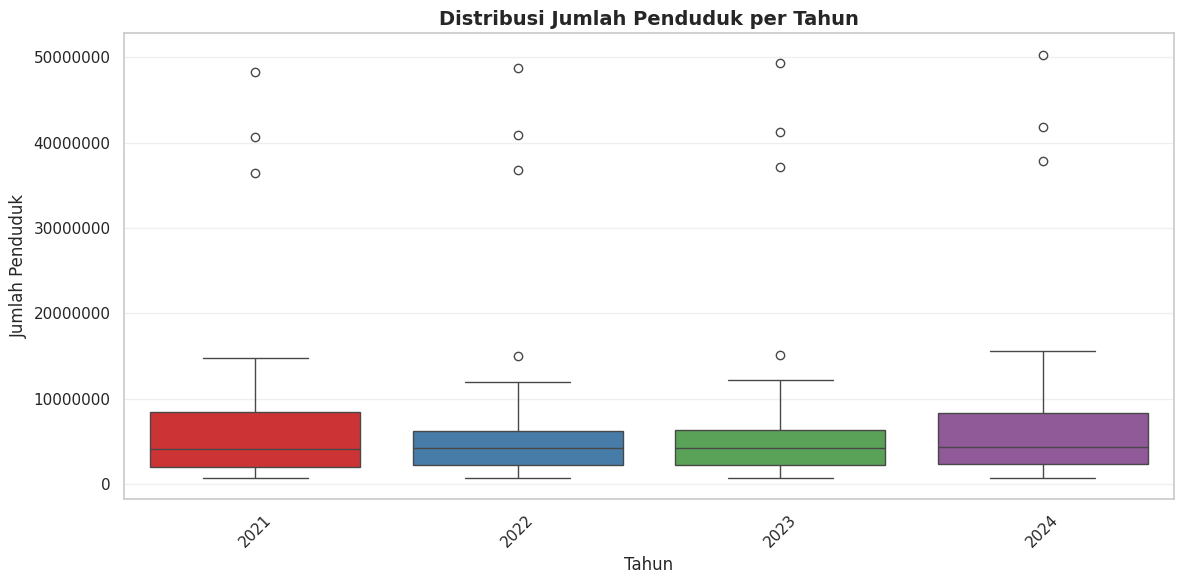

In [ ]:
# Pertanyaan 3: Distribusi per tahun (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pop_clean, x='Tahun', y='Jumlah_Penduduk', palette='Set1')
plt.title("Distribusi Jumlah Penduduk per Tahun", fontsize=14, fontweight='bold')
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penduduk")
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Distribusi Jumlah Penduduk Antar Provinsi per Tahun
*   Sebaran yang Konsisten: Secara umum, distribusi jumlah penduduk antar provinsi dari tahun 2021 hingga 2024 tidak menunjukkan perubahan ekstrem, menandakan stabilitas komposisi penduduk di tingkat provinsi.
*   Adanya Outlier: Setiap tahun terdapat beberapa provinsi dengan jumlah penduduk jauh lebih tinggi dibandingkan provinsi lainnya — kemungkinan besar provinsi-provinsi di Pulau Jawa seperti Jawa Barat, Jawa Timur, dan Jawa Tengah yang secara konsisten memiliki populasi besar.
*   Konsentrasi pada Nilai Rendah-Menengah: Sebagian besar provinsi memiliki jumlah penduduk dalam kisaran rendah hingga menengah, yang terlihat dari boxplot yang padat di bawah median, mengindikasikan ketimpangan distribusi penduduk antar wilayah.
*  Kenaikan Perlahan: Median jumlah penduduk cenderung meningkat secara bertahap setiap tahun, mencerminkan adanya pertumbuhan penduduk yang merata namun tetap didominasi oleh provinsi berpenduduk besar.




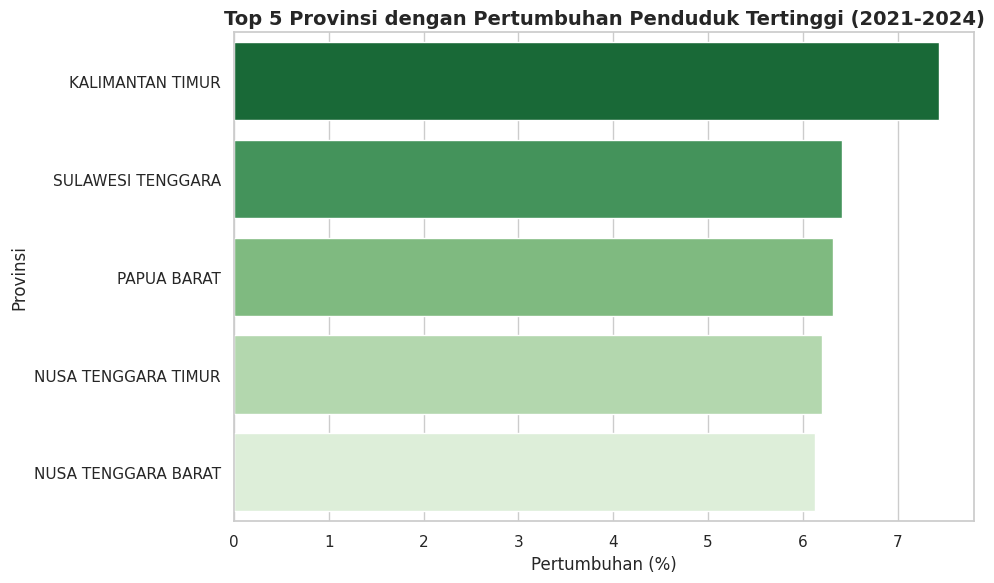

In [ ]:
# Pertanyaan 4: Pertumbuhan penduduk (delta tahun pertama vs terakhir)
if df_pop_clean['Tahun'].nunique() > 1:
    tahun_awal = df_pop_clean['Tahun'].min()
    tahun_akhir = df_pop_clean['Tahun'].max()

    pop_awal = df_pop_clean[df_pop_clean['Tahun'] == tahun_awal].groupby('Provinsi')['Jumlah_Penduduk'].sum()
    pop_akhir = df_pop_clean[df_pop_clean['Tahun'] == tahun_akhir].groupby('Provinsi')['Jumlah_Penduduk'].sum()

    growth = ((pop_akhir - pop_awal) / pop_awal * 100).sort_values(ascending=False).head(5)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=growth.values, y=growth.index, palette='Greens_r')
    plt.title(f"Top 5 Provinsi dengan Pertumbuhan Penduduk Tertinggi ({tahun_awal}-{tahun_akhir})", fontsize=14, fontweight='bold')
    plt.xlabel("Pertumbuhan (%)")
    plt.ylabel("Provinsi")
    plt.tight_layout()
    plt.show()


**INSIGHT:** Top 5 Provinsi dengan Pertumbuhan Penduduk Tertinggi (2021–2024)


*   Kalimantan Timur memiliki pertumbuhan tertinggi sebesar 7,4%, didorong oleh pembangunan Ibu Kota Negara baru.
*   Sulawesi Tenggara (6,5%), Papua Barat (6,3%), Nusa Tenggara Timur (6,2%), dan Nusa Tenggara Barat (6,1%) juga mencatat peningkatan signifikan karena aktivitas ekonomi dan urbanisasi.
*  Terjadi pergeseran pertumbuhan penduduk dari Pulau Jawa ke luar Jawa, terutama ke wilayah timur Indonesia.







## **EDA Gabungan (Merged Data Analysis)**

🔗 EXPLORATORY DATA ANALYSIS - DATA GABUNGAN

# **Hipotesis & Pertanyaan Eksplorasi Gabungan:**


1.   H1: Populasi berkorelasi positif dengan timbulan sampah
2.   H2: PDRB per kapita berkorelasi dengan infrastruktur sampah
3.   H3: Provinsi dengan penduduk banyak menghasilkan sampah banyak tapi infrastruktur kurang
4.   H4: Ada hubungan antara ekonomi (PDRB) dan pengelolaan sampah

1. Apakah jumlah penduduk berkorelasi dengan timbulan sampah?

In [ ]:
# Merge data untuk analisis gabungan
# Agregasi data waste per Provinsi-Tahun
df_waste_agg = df_waste_clean.groupby(['Provinsi', 'Tahun']).agg({
    'Timbulan_Tahunan_ton': 'sum',
    'Timbulan_Harian_ton': 'sum'
}).reset_index()

# Mulai merge
df_eda_merged = df_waste_agg.copy()

# Merge dengan Populasi
df_eda_merged = df_eda_merged.merge(
    df_pop_clean[['Provinsi', 'Tahun', 'Jumlah_Penduduk']],
    on=['Provinsi', 'Tahun'],
    how='inner'
)

2. Apakah PDRB per kapita berkorelasi dengan jumlah fasilitas infrastruktur?

In [ ]:
# Merge dengan PDRB
df_eda_merged = df_eda_merged.merge(
    df_pdrb_clean[['Provinsi', 'Tahun', 'PDRB_per_kapita_Rupiah']],
    on=['Provinsi', 'Tahun'],
    how='inner'
)

3. Provinsi mana yang memiliki rasio sampah per kapita tertinggi?

In [ ]:
# Merge dengan Infrastruktur
df_eda_merged = df_eda_merged.merge(
    df_infra_summary[['Provinsi', 'Tahun', 'Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton']],
    on=['Provinsi', 'Tahun'],
    how='inner'
)

4. Bagaimana hubungan antara PDRB, populasi, dan timbulan sampah?

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Salin dataframe agar aman
df_encoded = df_eda_merged.copy()

# Label encoding kolom 'Provinsi'
encoder = LabelEncoder()
df_encoded['Provinsi'] = encoder.fit_transform(df_encoded['Provinsi'])



In [ ]:
print(f"\n✅ Data berhasil digabungkan untuk EDA. Shape: {df_eda_merged.shape}")
print(f"Kolom yang tersedia: {df_eda_merged.columns.tolist()}")
print(f"\nContoh data gabungan:")
print(df_eda_merged.head(10))

# Statistik deskriptif data gabungan
print("\n📈 Statistik Deskriptif Data Gabungan:")
print(df_eda_merged.describe())

# Hitung rasio sampah per kapita (ton per 1000 penduduk)
df_eda_merged['Sampah_per_Kapita'] = (df_eda_merged['Timbulan_Tahunan_ton'] / df_eda_merged['Jumlah_Penduduk']) * 1000

# Hitung rasio fasilitas per juta penduduk
df_eda_merged['Fasilitas_per_Juta_Penduduk'] = (df_eda_merged['Jumlah_Fasilitas'] / df_eda_merged['Jumlah_Penduduk']) * 1000000


✅ Data berhasil digabungkan untuk EDA. Shape: (123, 8)
Kolom yang tersedia: ['Provinsi', 'Tahun', 'Timbulan_Tahunan_ton', 'Timbulan_Harian_ton', 'Jumlah_Penduduk', 'PDRB_per_kapita_Rupiah', 'Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton']

Contoh data gabungan:
  Provinsi  Tahun  Timbulan_Tahunan_ton  Timbulan_Harian_ton  Jumlah_Penduduk  \
0     ACEH   2022             598630.37              1640.10        5334900.0   
1     ACEH   2023             920435.58              2521.74        5409200.0   
2     ACEH   2024             931689.39              2552.58        5554800.0   
3     BALI   2021             915482.47              2508.18        4317400.0   
4     BALI   2022            1027433.75              2814.89        4343400.0   
5     BALI   2023            1229234.65              3367.78        4374300.0   
6     BALI   2024            1254235.02              3436.28        4433300.0   
7   BANTEN   2021             795829.76              2180.36       11904600.0   
8   BANTEN  

# **3. DATA VISUALISASI — BERDASARKAN HIPOTESIS EDA**

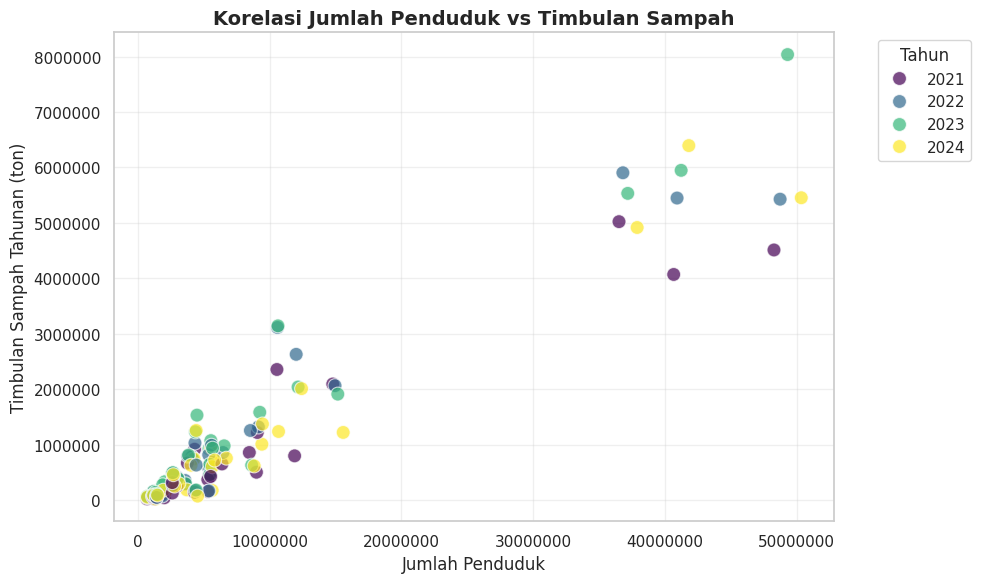

In [ ]:
# Pertanyaan 1: Korelasi Penduduk vs Timbulan Sampah
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda_merged, x='Jumlah_Penduduk', y='Timbulan_Tahunan_ton',
                hue='Tahun', palette='viridis', s=100, alpha=0.7)
plt.title("Korelasi Jumlah Penduduk vs Timbulan Sampah", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Penduduk")
plt.ylabel("Timbulan Sampah Tahunan (ton)")
plt.ticklabel_format(style='plain')
plt.legend(title='Tahun', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Korelasi Jumlah Penduduk vs Timbulan Sampah

*   Hubungan Positif yang Kuat: Terlihat adanya korelasi positif antara jumlah penduduk dan timbulan sampah. Semakin besar jumlah penduduk di suatu provinsi, semakin tinggi pula volume sampah yang dihasilkan.
*   Pola Konsisten Antar Tahun: Pada seluruh tahun (2021–2024), pola sebaran titik tetap serupa — provinsi dengan penduduk di atas 30–50 juta jiwa menghasilkan timbulan sampah tahunan hingga 5–8 juta ton, sementara provinsi dengan penduduk di bawah 10 juta jiwa umumnya menghasilkan kurang dari 1 juta ton per tahun.
*   Provinsi Padat Penduduk Jadi Penyumbang Utama: Provinsi seperti Jawa Barat, Jawa Timur, dan Jawa Tengah yang memiliki populasi tertinggi (sekitar 35–50 juta jiwa) juga menjadi penyumbang timbulan sampah terbesar, mencapai lebih dari 6 juta ton per tahun.
*   Sebaran di Wilayah Berpenduduk Rendah: Provinsi dengan jumlah penduduk kecil (di bawah 5 juta jiwa) menunjukkan timbulan sampah relatif rendah, umumnya di bawah 500 ribu ton per tahun, menunjukkan kontribusi yang lebih kecil terhadap total nasional.
*  Implikasi: Hasil ini menegaskan bahwa pengelolaan sampah nasional harus difokuskan pada provinsi dengan populasi besar, karena peningkatan penduduk secara langsung berdampak pada naiknya volume sampah. Upaya pengurangan sampah rumah tangga dan peningkatan fasilitas daur ulang perlu diprioritaskan di wilayah berpenduduk padat.






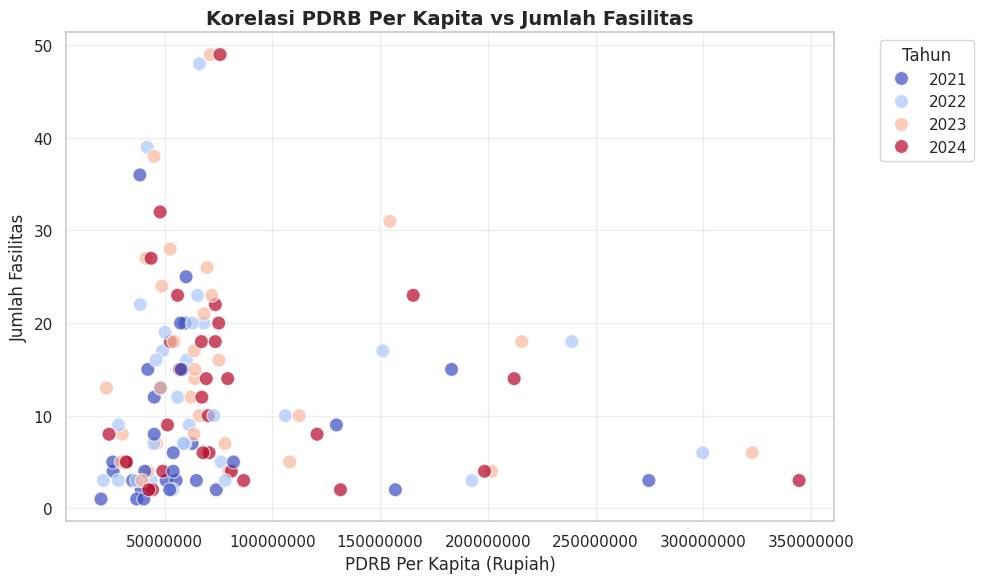

In [ ]:
# Pertanyaan 2: Korelasi PDRB vs Jumlah Fasilitas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_eda_merged, x='PDRB_per_kapita_Rupiah', y='Jumlah_Fasilitas',
                hue='Tahun', palette='coolwarm', s=100, alpha=0.7)
plt.title("Korelasi PDRB Per Kapita vs Jumlah Fasilitas", fontsize=14, fontweight='bold')
plt.xlabel("PDRB Per Kapita (Rupiah)")
plt.ylabel("Jumlah Fasilitas")
plt.ticklabel_format(style='plain', axis='x')
plt.legend(title='Tahun', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:**  Korelasi PDRB Per Kapita vs Jumlah Fasilitas
*   Korelasi Lemah: Tidak terlihat hubungan yang kuat antara PDRB per kapita dan jumlah fasilitas infrastruktur.
*   Sebaran Tidak Teratur: Provinsi dengan PDRB tinggi belum tentu memiliki fasilitas lebih banyak — titik-titik data tersebar acak.
*   Contoh Pola: Banyak provinsi dengan PDRB di bawah 10 juta justru memiliki jumlah fasilitas tinggi (20–40 unit), sedangkan daerah ber-PDRB tinggi (hingga 35 juta) cenderung memiliki fasilitas lebih sedikit (<10).
*   Kesimpulan: Tingginya pendapatan per kapita tidak selalu diikuti oleh peningkatan jumlah fasilitas. Faktor lain seperti kebijakan daerah, prioritas pembangunan, dan kepadatan penduduk kemungkinan lebih berpengaruh terhadap jumlah fasilitas yang tersedia.

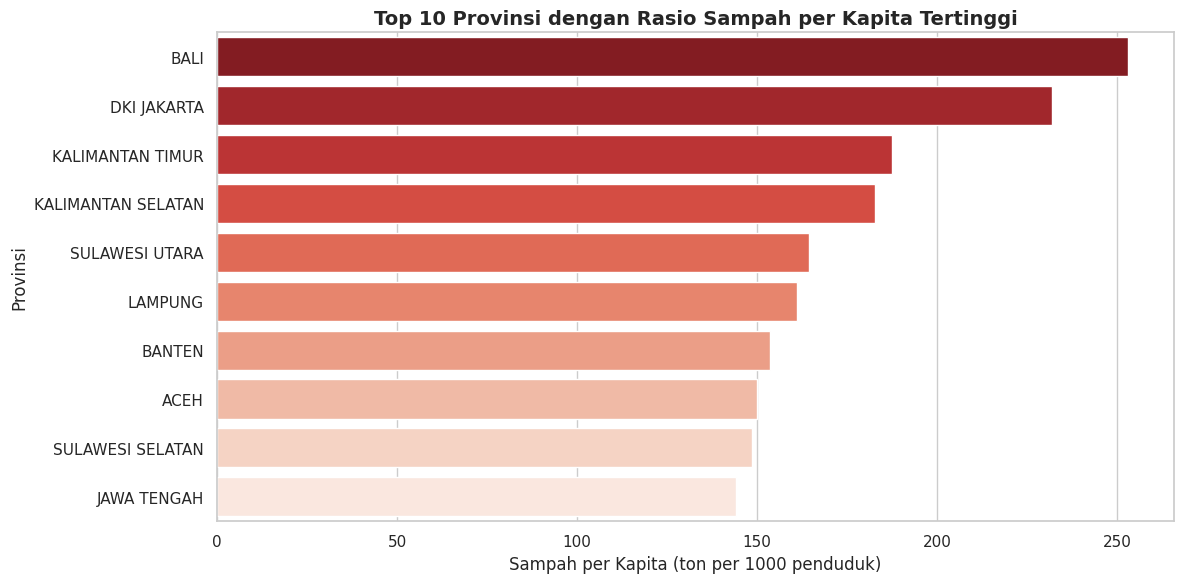

In [ ]:
# Pertanyaan 3: Top 10 Provinsi dengan Rasio Sampah per Kapita Tertinggi
top_rasio_sampah = df_eda_merged.groupby('Provinsi')['Sampah_per_Kapita'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rasio_sampah.values, y=top_rasio_sampah.index, palette='Reds_r')
plt.title("Top 10 Provinsi dengan Rasio Sampah per Kapita Tertinggi", fontsize=14, fontweight='bold')
plt.xlabel("Sampah per Kapita (ton per 1000 penduduk)")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()

**INSIGHT:** Rasio Sampah per Kapita Tertinggi

*  Provinsi dengan rasio sampah per kapita tertinggi adalah Bali, mencapai sekitar 250 ton per 1000 penduduk.
*   Posisi berikutnya ditempati oleh DKI Jakarta (±230 ton) dan Kalimantan Timur (±190 ton).
*  Angka ini menunjukkan bahwa provinsi dengan aktivitas pariwisata atau urbanisasi tinggi cenderung menghasilkan sampah lebih banyak per individu.
*  Sebaliknya, provinsi seperti Jawa Tengah dan Sulawesi Selatan memiliki rasio lebih rendah (sekitar 140–150 ton per 1000 penduduk).
*   Kesimpulan: Tingginya rasio sampah per kapita di Bali dan DKI Jakarta mengindikasikan bahwa kepadatan penduduk dan gaya hidup konsumtif berperan besar dalam peningkatan volume sampah.

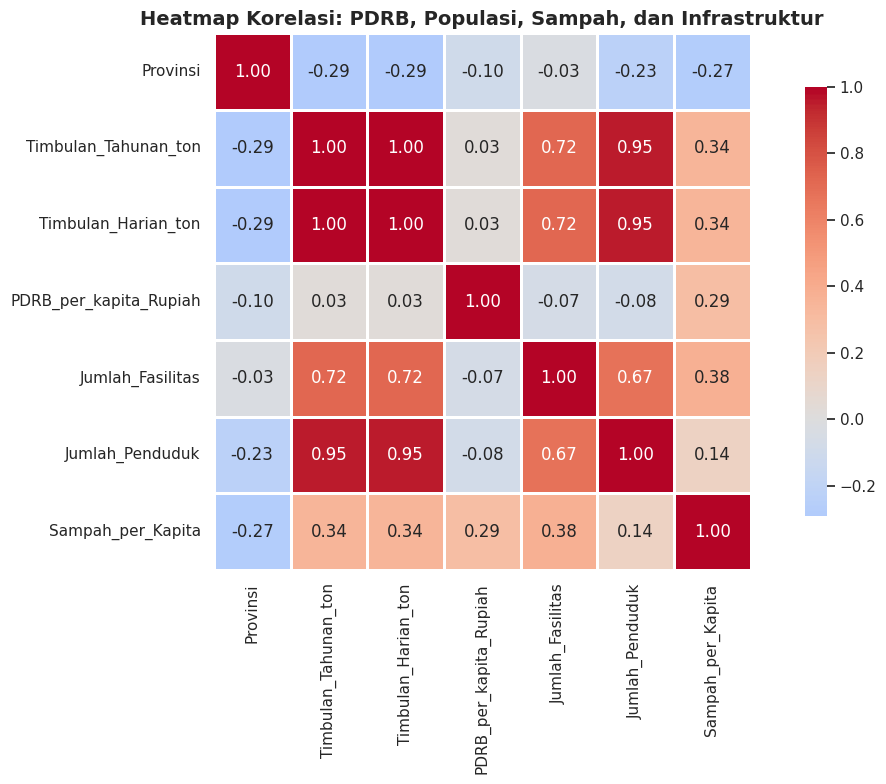

In [ ]:
# Pertanyaan 4: Heatmap Korelasi Semua Variabel Numerik
from sklearn.preprocessing import LabelEncoder

# Salin dataframe agar aman
df_encoded = df_eda_merged.copy()

# Label encoding kolom 'Provinsi'
encoder = LabelEncoder()
df_encoded['Provinsi'] = encoder.fit_transform(df_encoded['Provinsi'])

# Lanjutkan ke heatmap korelasi
plt.figure(figsize=(12, 8))
correlation_cols = ['Provinsi','Timbulan_Tahunan_ton', 'Timbulan_Harian_ton',
                    'PDRB_per_kapita_Rupiah', 'Jumlah_Fasilitas',
                    'Jumlah_Penduduk', 'Sampah_per_Kapita']

correlation_matrix = df_encoded[correlation_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Heatmap Korelasi: PDRB, Populasi, Sampah, dan Infrastruktur",
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**INSIGHT:** Hubungan antara PDRB, Populasi, dan Timbulan Sampah
*   Jumlah penduduk memiliki korelasi sangat kuat dengan timbulan sampah tahunan (r = 0,95) dan timbulan sampah harian (r = 0,95).Artinya, semakin besar populasi suatu provinsi, semakin tinggi volume sampah yang dihasilkan.
*   PDRB per kapita hampir tidak berkorelasi dengan timbulan sampah (r = 0,03) maupun dengan jumlah penduduk (r = -0,08).Ini menunjukkan bahwa kekayaan atau tingkat ekonomi tidak selalu menentukan banyaknya sampah yang dihasilkan, melainkan lebih dipengaruhi oleh jumlah penduduk.
*   Jumlah fasilitas memiliki korelasi sedang terhadap timbulan sampah (r = 0,72) dan populasi (r = 0,67), menandakan bahwa wilayah dengan penduduk padat dan aktivitas ekonomi tinggi cenderung memiliki lebih banyak fasilitas dan volume sampah yang besar.

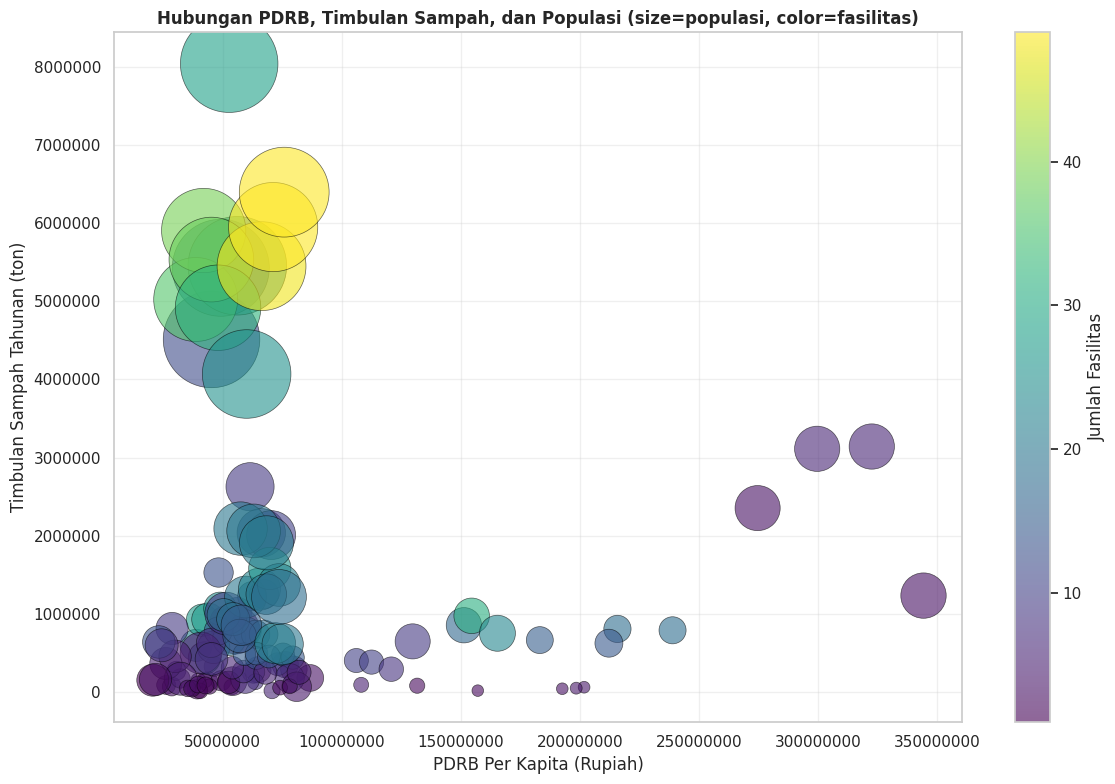

In [ ]:
# Visualisasi tambahan: Bubble chart (3 variabel)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_eda_merged['PDRB_per_kapita_Rupiah'],
                     df_eda_merged['Timbulan_Tahunan_ton'],
                     s=df_eda_merged['Jumlah_Penduduk']/10000,  # Size berdasarkan populasi
                     c=df_eda_merged['Jumlah_Fasilitas'],  # Warna berdasarkan fasilitas
                     alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Jumlah Fasilitas')
plt.title("Hubungan PDRB, Timbulan Sampah, dan Populasi (size=populasi, color=fasilitas)",
         fontsize=12, fontweight='bold')
plt.xlabel("PDRB Per Kapita (Rupiah)")
plt.ylabel("Timbulan Sampah Tahunan (ton)")
plt.ticklabel_format(style='plain')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**INSIGHT:** Hubungan PDRB, Timbulan Sampah, dan Populasi
*  Terlihat bahwa provinsi dengan PDRB per kapita rendah hingga menengah justru memiliki timbulan sampah tahunan yang tinggi, terutama pada wilayah dengan populasi besar (gelembung berukuran besar).
*   Provinsi dengan jumlah fasilitas pengelolaan sampah lebih banyak (warna kuning-hijau) umumnya berada di kelompok PDRB rendah hingga menengah, menandakan upaya pengelolaan sampah lebih intens di wilayah padat penduduk.
*   Sebaliknya, wilayah dengan PDRB tinggi cenderung memiliki timbulan sampah yang lebih rendah, meskipun jumlah fasilitasnya lebih sedikit (warna ungu).
*   Pola ini menunjukkan bahwa tingginya pendapatan daerah (PDRB) tidak selalu sejalan dengan tingginya volume sampah, melainkan lebih dipengaruhi oleh jumlah penduduk dan ketersediaan fasilitas pengelolaan.
*  Kesimpulan: Faktor populasi dan infrastruktur pengelolaan sampah memiliki pengaruh lebih besar terhadap volume sampah dibandingkan tingkat PDRB per kapita semata.

## **ANALISIS LANJUTAN: RULE-BASED GROUPING**

📊 Median PDRB per Kapita: 59,502,640
📊 Median Timbulan Sampah Tahunan: 598,630

📈 Distribusi Kategori Rule-Based:
                Kategori_Rule  Jumlah_Provinsi
0  High Economic - High Waste               10
1   High Economic - Low Waste                9
2   Low Economic - High Waste               13
3    Low Economic - Low Waste               13


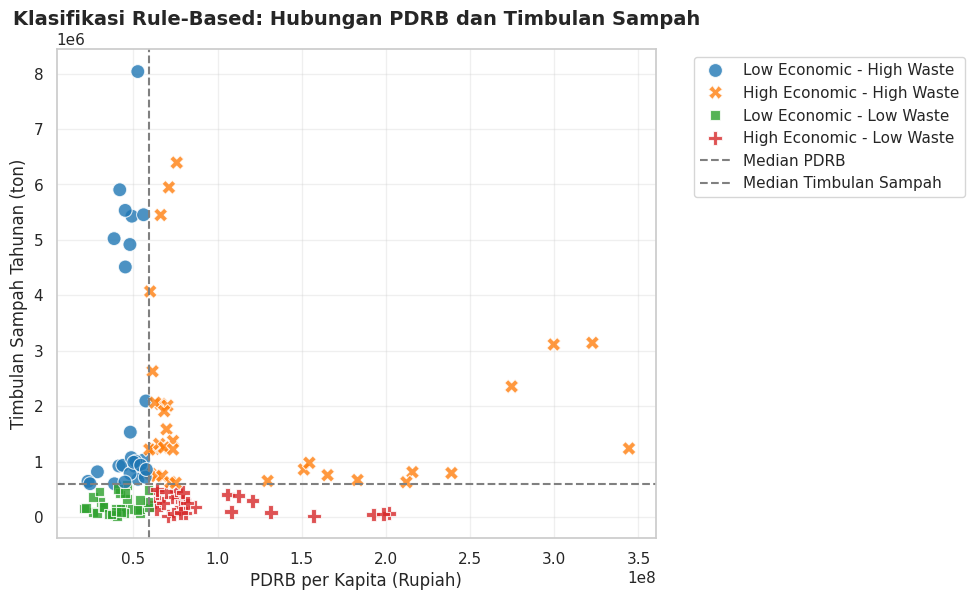

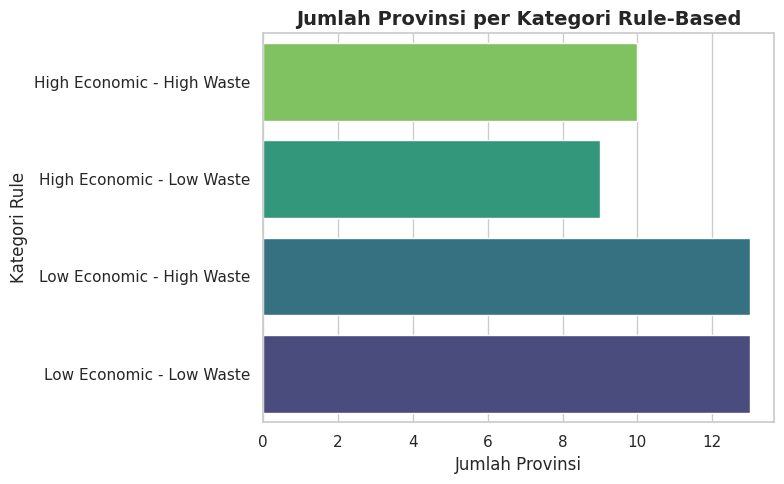


📊 Rata-rata indikator utama per kategori:


,PDRB_per_kapita_Rupiah,Timbulan_Tahunan_ton,Jumlah_Penduduk,Sampah_per_Kapita
Kategori_Rule,,,,
High Economic - High Waste,1.227094e+08,1835929.55,12219317.65,164.04
High Economic - Low Waste,9.713678e+07,233174.40,2414960.71,93.11
Low Economic - High Waste,4.678219e+07,2262146.61,16875200.00,149.75
Low Economic - Low Waste,4.092247e+07,206356.21,3053148.48,70.79


In [ ]:
# Tentukan batas (threshold) berdasarkan median
pdrb_median = df_eda_merged['PDRB_per_kapita_Rupiah'].median()
sampah_median = df_eda_merged['Timbulan_Tahunan_ton'].median()

print(f"📊 Median PDRB per Kapita: {pdrb_median:,.0f}")
print(f"📊 Median Timbulan Sampah Tahunan: {sampah_median:,.0f}")

# Fungsi untuk menentukan kategori rule-based
def classify_rule(row):
    if row['PDRB_per_kapita_Rupiah'] >= pdrb_median and row['Timbulan_Tahunan_ton'] >= sampah_median:
        return 'High Economic - High Waste'
    elif row['PDRB_per_kapita_Rupiah'] >= pdrb_median and row['Timbulan_Tahunan_ton'] < sampah_median:
        return 'High Economic - Low Waste'
    elif row['PDRB_per_kapita_Rupiah'] < pdrb_median and row['Timbulan_Tahunan_ton'] >= sampah_median:
        return 'Low Economic - High Waste'
    else:
        return 'Low Economic - Low Waste'

# Terapkan rule
df_eda_merged['Kategori_Rule'] = df_eda_merged.apply(classify_rule, axis=1)

# Hitung jumlah provinsi unik per kategori
rule_counts = df_eda_merged.groupby('Kategori_Rule')['Provinsi'].nunique().reset_index()
rule_counts.rename(columns={'Provinsi': 'Jumlah_Provinsi'}, inplace=True)

print("\n📈 Distribusi Kategori Rule-Based:")
print(rule_counts)

# ============================================================================
# 🔹 VISUALISASI 1: Scatter Plot PDRB vs Timbulan Sampah per Kategori Rule
# ============================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_eda_merged,
    x='PDRB_per_kapita_Rupiah',
    y='Timbulan_Tahunan_ton',
    hue='Kategori_Rule',
    style='Kategori_Rule',
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.axvline(pdrb_median, color='gray', linestyle='--', label='Median PDRB')
plt.axhline(sampah_median, color='gray', linestyle='--', label='Median Timbulan Sampah')
plt.title("Klasifikasi Rule-Based: Hubungan PDRB dan Timbulan Sampah", fontsize=14, fontweight='bold')
plt.xlabel("PDRB per Kapita (Rupiah)")
plt.ylabel("Timbulan Sampah Tahunan (ton)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 🔹 VISUALISASI 2: Jumlah Provinsi per Kategori Rule
# ============================================================================
plt.figure(figsize=(8, 5))
sns.barplot(
    data=rule_counts,
    x='Jumlah_Provinsi',
    y='Kategori_Rule',
    palette='viridis_r'
)
plt.title("Jumlah Provinsi per Kategori Rule-Based", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Provinsi")
plt.ylabel("Kategori Rule")
plt.tight_layout()
plt.show()

# ============================================================================
# 🔹 ANALISIS TAMBAHAN (OPSIONAL)
# ============================================================================
# Rata-rata indikator per kategori
rule_summary = df_eda_merged.groupby('Kategori_Rule')[[
    'PDRB_per_kapita_Rupiah', 'Timbulan_Tahunan_ton', 'Jumlah_Penduduk', 'Sampah_per_Kapita'
]].mean().round(2)

print("\n📊 Rata-rata indikator utama per kategori:")
display(rule_summary)


**INSIGHT :** Visualisasi Rule-Based:


*  Hasil analisis rule-based grouping dilakukan dengan menggunakan dua variabel utama, yaitu PDRB per kapita dan Timbulan Sampah Tahunan. Nilai median PDRB per kapita diperoleh sebesar Rp59,502,640, sedangkan median timbulan sampah tahunan sebesar 598,630 ton. Kedua nilai median tersebut digunakan sebagai batas untuk membentuk empat kategori daerah, yaitu:

- High Economic – High Waste

- High Economic – Low Waste

- Low Economic – High Waste

- Low Economic – Low Waste


*  Scatter plot menampilkan sebaran data tiap provinsi terhadap kedua variabel tersebut. Garis vertikal menunjukkan batas median PDRB per kapita, dan garis horizontal menunjukkan batas median timbulan sampah. Sebaran data terlihat membentuk empat area utama sesuai kategori rule-based.
*   Sementara itu, grafik batang menunjukkan jumlah provinsi di masing-masing kategori. Berdasarkan hasil pengelompokan, kategori Low Economic – Low Waste memiliki jumlah provinsi terbanyak, diikuti oleh Low Economic – High Waste, High Economic – Low Waste, dan High Economic – High Waste yang jumlahnya paling sedikit.
*   Temuan ini menggambarkan bahwa sebagian besar provinsi di Indonesia masih berada pada tingkat ekonomi dan timbulan sampah yang relatif rendah. Pendekatan rule-based ini membantu memberikan gambaran umum tentang pola hubungan antara kondisi ekonomi daerah dan tingkat timbulan sampah yang dihasilkan.









In [ ]:
# ==============================================================================
# BAGIAN 8: PEMBANGUNAN MODEL LATIH (MODELING) - DENGAN STANDARDISASI METRIK
# Tujuan: Memprediksi Timbulan Sampah Tahunan berdasarkan faktor ekonomi,
#         infrastruktur, dan populasi
# ==============================================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

print("\n" + "="*80)
print("🤖 BAGIAN 8: PEMBANGUNAN MODEL PREDIKSI TIMBULAN SAMPAH")
print("="*80)


🤖 BAGIAN 8: PEMBANGUNAN MODEL PREDIKSI TIMBULAN SAMPAH


In [ ]:
# ------------------------------------------------------------------------------
# 8.1 MERGE SEMUA DATASET YANG RELEVAN
# ------------------------------------------------------------------------------
print("\n📊 Step 1: Menggabungkan semua dataset...")

# Agregasi data waste per Provinsi-Tahun (sum timbulan tahunan)
df_waste_agg = df_waste_clean.groupby(['Provinsi', 'Tahun']).agg({
    'Timbulan_Tahunan_ton': 'sum',
    'Timbulan_Harian_ton': 'sum'
}).reset_index()

# Start merging
df_model = df_waste_agg.copy()

# Merge dengan PDRB
df_model = df_model.merge(
    df_pdrb_clean[['Provinsi', 'Tahun', 'PDRB_per_kapita_Rupiah']],
    on=['Provinsi', 'Tahun'],
    how='left'
)

# Merge dengan Infrastruktur
df_model = df_model.merge(
    df_infra_summary[['Provinsi', 'Tahun', 'Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton']],
    on=['Provinsi', 'Tahun'],
    how='left'
)

# Merge dengan Populasi
df_model = df_model.merge(
    df_pop_clean[['Provinsi', 'Tahun', 'Jumlah_Penduduk']],
    on=['Provinsi', 'Tahun'],
    how='left'
)

print(f"✅ Dataset berhasil digabungkan. Shape: {df_model.shape}")
print(f"\nKolom-kolom yang tersedia:")
print(df_model.columns.tolist())

# ------------------------------------------------------------------------------
# 8.2 CLEANING & IMPUTASI NILAI HILANG SECARA CERDAS
# ------------------------------------------------------------------------------
print("\n🧹 Step 2: Membersihkan dan mengimputasi missing values (tanpa menghapus data)...")

# 1️⃣ Cek kondisi awal missing
print("Missing values sebelum dibersihkan:")
print(df_model.isnull().sum())

# 2️⃣ Konversi kolom numerik ke float
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in num_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# 3️⃣ Tangani nilai ekstrim tidak logis
if 'Infra_Sampahmasuk_ton' in df_model.columns:
    df_model['Infra_Sampahmasuk_ton'] = df_model['Infra_Sampahmasuk_ton'].apply(
        lambda x: np.nan if pd.notna(x) and x > 1e8 else x
    )

# 4️⃣ Imputasi berdasarkan median per Provinsi
cols_impute_median = [
    'PDRB_per_kapita_Rupiah',
    'Jumlah_Fasilitas',
    'Infra_Sampahmasuk_ton'
]

for col in cols_impute_median:
    if col in df_model.columns:
        df_model[col] = df_model.groupby('Provinsi')[col].transform(
            lambda x: x.fillna(x.median())
        )

# 5️⃣ Imputasi kolom populasi menggunakan rata-rata per provinsi
if 'Jumlah_Penduduk' in df_model.columns:
    df_model['Jumlah_Penduduk'] = df_model.groupby('Provinsi')['Jumlah_Penduduk'].transform(
        lambda x: x.fillna(x.mean())
    )

# 6️⃣ Jika masih ada nilai hilang, isi dengan median global
df_model = df_model.fillna(df_model.median(numeric_only=True))

# 7️⃣ Imputasi kolom kategorikal
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    if not df_model[col].mode().empty:
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0])
    else:
        df_model[col] = df_model[col].fillna('Unknown')

# 8️⃣ Hapus duplikat & reset index
df_model = df_model.drop_duplicates().reset_index(drop=True)

# 9️⃣ Buat salinan untuk model
df_model_clean = df_model.copy()

# 🔟 Laporan akhir
print("\n✅ Missing values setelah imputasi dan cleaning:")
print(df_model_clean.isnull().sum())
print(f"\n✅ Dataset setelah cleaning dan imputasi. Shape: {df_model_clean.shape}")


📊 Step 1: Menggabungkan semua dataset...
✅ Dataset berhasil digabungkan. Shape: (221, 8)

Kolom-kolom yang tersedia:
['Provinsi', 'Tahun', 'Timbulan_Tahunan_ton', 'Timbulan_Harian_ton', 'PDRB_per_kapita_Rupiah', 'Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton', 'Jumlah_Penduduk']

🧹 Step 2: Membersihkan dan mengimputasi missing values (tanpa menghapus data)...
Missing values sebelum dibersihkan:
Provinsi                   0
Tahun                      0
Timbulan_Tahunan_ton       0
Timbulan_Harian_ton        0
PDRB_per_kapita_Rupiah    17
Jumlah_Fasilitas          41
Infra_Sampahmasuk_ton     41
Jumlah_Penduduk           98
dtype: int64

✅ Missing values setelah imputasi dan cleaning:
Provinsi                  0
Tahun                     0
Timbulan_Tahunan_ton      0
Timbulan_Harian_ton       0
PDRB_per_kapita_Rupiah    0
Jumlah_Fasilitas          0
Infra_Sampahmasuk_ton     0
Jumlah_Penduduk           0
dtype: int64

✅ Dataset setelah cleaning dan imputasi. Shape: (221, 8)


In [ ]:
# ------------------------------------------------------------------------------
# 8.3 SELEKSI FITUR DAN TARGET
# ------------------------------------------------------------------------------
print("\n🎯 Step 3: Memilih fitur prediktor dan target...")

# Fitur-fitur prediktor
feature_cols = [
    'PDRB_per_kapita_Rupiah',
    'Jumlah_Fasilitas',
    'Infra_Sampahmasuk_ton',
    'Jumlah_Penduduk',
]

# Target
target_col = 'Timbulan_Tahunan_ton'

# Pastikan semua kolom ada dan tidak ada nilai null
available_features = [f for f in feature_cols if f in df_model_clean.columns]
print(f"Fitur yang tersedia: {available_features}")

# Hapus baris dengan nilai null di fitur atau target
cols_to_check = available_features + [target_col]
df_model_clean = df_model_clean.dropna(subset=cols_to_check)

X = df_model_clean[available_features]
y = df_model_clean[target_col]

print(f"✅ Fitur (X) shape: {X.shape}")
print(f"✅ Target (y) shape: {y.shape}")
print(f"✅ Dataset final untuk modeling: {df_model_clean.shape[0]} sampel")


🎯 Step 3: Memilih fitur prediktor dan target...
Fitur yang tersedia: ['PDRB_per_kapita_Rupiah', 'Jumlah_Fasilitas', 'Infra_Sampahmasuk_ton', 'Jumlah_Penduduk']
✅ Fitur (X) shape: (221, 4)
✅ Target (y) shape: (221,)
✅ Dataset final untuk modeling: 221 sampel


In [ ]:
# ------------------------------------------------------------------------------
# 8.4 SPLIT TRAIN-TEST (80-20)
# ------------------------------------------------------------------------------
print("\n✂️ Step 4: Membagi data menjadi train dan test (80-20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Train set: {X_train.shape[0]} sampel")
print(f"✅ Test set: {X_test.shape[0]} sampel")


✂️ Step 4: Membagi data menjadi train dan test (80-20)...
✅ Train set: 176 sampel
✅ Test set: 45 sampel


In [ ]:
# ------------------------------------------------------------------------------
# 8.5 NORMALISASI FITUR DAN TARGET MENGGUNAKAN MINMAXSCALER
# ------------------------------------------------------------------------------
print("\n⚙️ Step 5: Normalisasi fitur dan target menggunakan MinMaxScaler...")

# Normalisasi fitur (X)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalisasi target (y) - PENTING: reshape untuk scaler
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("✅ Fitur berhasil dinormalisasi menggunakan MinMaxScaler")
print("✅ Target berhasil dinormalisasi menggunakan MinMaxScaler")
print(f"\n📊 Range target setelah normalisasi:")
print(f"   Train - Min: {y_train_scaled.min():.4f}, Max: {y_train_scaled.max():.4f}")
print(f"   Test  - Min: {y_test_scaled.min():.4f}, Max: {y_test_scaled.max():.4f}")


⚙️ Step 5: Normalisasi fitur dan target menggunakan MinMaxScaler...
✅ Fitur berhasil dinormalisasi menggunakan MinMaxScaler
✅ Target berhasil dinormalisasi menggunakan MinMaxScaler

📊 Range target setelah normalisasi:
   Train - Min: 0.0000, Max: 1.0000
   Test  - Min: 0.0009, Max: 0.5264


In [ ]:
# ------------------------------------------------------------------------------
# 8.6 MELATIH DAN MEMBANDINGKAN 3 MODEL REGRESI
# ------------------------------------------------------------------------------
print("\n🏋️ Step 6: Melatih dan membandingkan 3 model regresi...")

# Inisialisasi model
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Dictionary untuk menyimpan hasil
results = {}

print("\n" + "-"*80)
for model_name, model in models.items():
    print(f"\n🔄 Melatih model: {model_name}...")

    # Train model dengan data yang sudah dinormalisasi
    model.fit(X_train_scaled, y_train_scaled)

    # Prediksi (hasil dalam skala normalized)
    y_pred_scaled = model.predict(X_test_scaled)

    # Evaluasi pada skala normalized (MAE dan RMSE sudah otomatis terstandarisasi 0-1)
    r2_scaled = r2_score(y_test_scaled, y_pred_scaled)
    mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
    rmse_scaled = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))

    # Inverse transform untuk mendapatkan nilai asli (untuk interpretasi)
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Evaluasi pada skala asli
    r2_original = r2_score(y_test, y_pred_original)
    mae_original = mean_absolute_error(y_test, y_pred_original)
    rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))

    # Simpan hasil
    results[model_name] = {
        'model': model,
        'y_pred_scaled': y_pred_scaled,
        'y_pred_original': y_pred_original,
        'R2_scaled': r2_scaled,
        'MAE_scaled': mae_scaled,
        'RMSE_scaled': rmse_scaled,
        'R2_original': r2_original,
        'MAE_original': mae_original,
        'RMSE_original': rmse_original
    }

    print(f"\n   📏 METRIK TERSTANDARISASI (0-1):")
    print(f"      R² Score: {r2_scaled:.4f}")
    print(f"      MAE: {mae_scaled:.4f}")
    print(f"      RMSE: {rmse_scaled:.4f}")
    print(f"\n   📊 METRIK SKALA ASLI:")
    print(f"      R² Score: {r2_original:.4f}")
    print(f"      MAE: {mae_original:,.2f} ton")
    print(f"      RMSE: {rmse_original:,.2f} ton")

print("\n" + "-"*80)


🏋️ Step 6: Melatih dan membandingkan 3 model regresi...

--------------------------------------------------------------------------------

🔄 Melatih model: Linear Regression...

   📏 METRIK TERSTANDARISASI (0-1):
      R² Score: 0.8845
      MAE: 0.0233
      RMSE: 0.0338

   📊 METRIK SKALA ASLI:
      R² Score: 0.8845
      MAE: 187,092.78 ton
      RMSE: 271,244.68 ton

🔄 Melatih model: Random Forest...

   📏 METRIK TERSTANDARISASI (0-1):
      R² Score: 0.9218
      MAE: 0.0182
      RMSE: 0.0278

   📊 METRIK SKALA ASLI:
      R² Score: 0.9218
      MAE: 146,384.94 ton
      RMSE: 223,224.91 ton

🔄 Melatih model: XGBoost...

   📏 METRIK TERSTANDARISASI (0-1):
      R² Score: 0.8838
      MAE: 0.0212
      RMSE: 0.0339

   📊 METRIK SKALA ASLI:
      R² Score: 0.8838
      MAE: 169,781.58 ton
      RMSE: 272,053.50 ton

--------------------------------------------------------------------------------


In [ ]:
# ------------------------------------------------------------------------------
# 8.7 EVALUASI DAN PERBANDINGAN MODEL
# ------------------------------------------------------------------------------
print("\n📈 Step 7: Ringkasan Performa Model")
print("\n" + "="*80)

# Buat DataFrame perbandingan - METRIK TERSTANDARISASI
comparison_df_scaled = pd.DataFrame({
    'Model': list(results.keys()),
    'R² Score': [results[m]['R2_scaled'] for m in results.keys()],
    'MAE (Normalized)': [results[m]['MAE_scaled'] for m in results.keys()],
    'RMSE (Normalized)': [results[m]['RMSE_scaled'] for m in results.keys()]
})

print("📏 METRIK EVALUASI TERSTANDARISASI (Range 0-1):")
print(comparison_df_scaled.to_string(index=False))

# Buat DataFrame perbandingan - METRIK ASLI
comparison_df_original = pd.DataFrame({
    'Model': list(results.keys()),
    'R² Score': [results[m]['R2_original'] for m in results.keys()],
    'MAE (ton)': [results[m]['MAE_original'] for m in results.keys()],
    'RMSE (ton)': [results[m]['RMSE_original'] for m in results.keys()]
})

print("\n📊 METRIK EVALUASI SKALA ASLI:")
print(comparison_df_original.to_string(index=False))
print("="*80)

# Tentukan model terbaik (berdasarkan R² pada skala normalized)
best_model_name = comparison_df_scaled.loc[comparison_df_scaled['R² Score'].idxmax(), 'Model']
best_model = results[best_model_name]['model']
best_y_pred_scaled = results[best_model_name]['y_pred_scaled']
best_y_pred_original = results[best_model_name]['y_pred_original']

print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
print(f"\n📏 Metrik Terstandarisasi (0-1):")
print(f"   R² Score: {results[best_model_name]['R2_scaled']:.4f}")
print(f"   MAE: {results[best_model_name]['MAE_scaled']:.4f}")
print(f"   RMSE: {results[best_model_name]['RMSE_scaled']:.4f}")
print(f"\n📊 Metrik Skala Asli:")
print(f"   R² Score: {results[best_model_name]['R2_original']:.4f}")
print(f"   MAE: {results[best_model_name]['MAE_original']:,.2f} ton")
print(f"   RMSE: {results[best_model_name]['RMSE_original']:,.2f} ton")


📈 Step 7: Ringkasan Performa Model

📏 METRIK EVALUASI TERSTANDARISASI (Range 0-1):
            Model  R² Score  MAE (Normalized)  RMSE (Normalized)
Linear Regression  0.884510          0.023314           0.033800
    Random Forest  0.921782          0.018241           0.027816
          XGBoost  0.883821          0.021157           0.033901

📊 METRIK EVALUASI SKALA ASLI:
            Model  R² Score     MAE (ton)    RMSE (ton)
Linear Regression  0.884510 187092.776180 271244.682767
    Random Forest  0.921782 146384.942120 223224.910870
          XGBoost  0.883821 169781.584188 272053.495199

🏆 MODEL TERBAIK: Random Forest

📏 Metrik Terstandarisasi (0-1):
   R² Score: 0.9218
   MAE: 0.0182
   RMSE: 0.0278

📊 Metrik Skala Asli:
   R² Score: 0.9218
   MAE: 146,384.94 ton
   RMSE: 223,224.91 ton



📊 Step 8: Visualisasi perbandingan performa model...


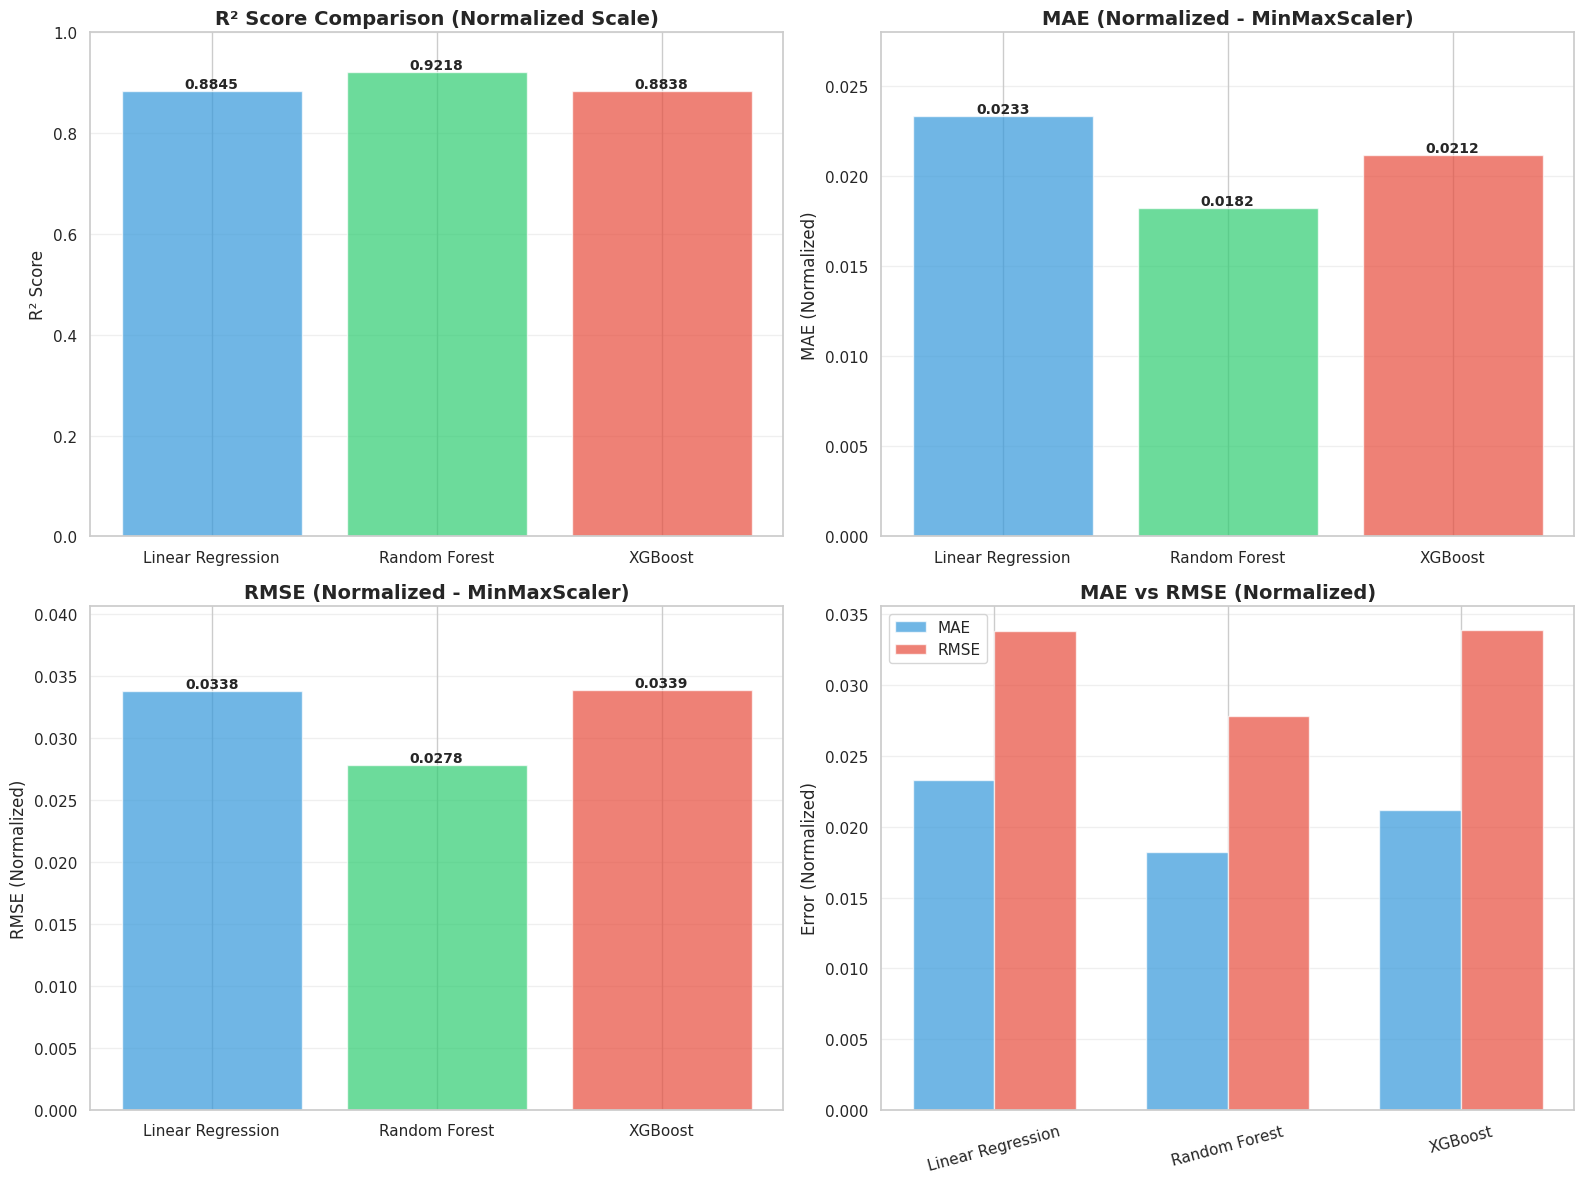

In [ ]:
# ------------------------------------------------------------------------------
# 8.8 VISUALISASI PERBANDINGAN PERFORMA MODEL
# ------------------------------------------------------------------------------
print("\n📊 Step 8: Visualisasi perbandingan performa model...")

# Subplot untuk berbagai metrik
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['#3498db', '#2ecc71', '#e74c3c']

# 1. R² Score (Normalized)
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df_scaled['Model'], comparison_df_scaled['R² Score'],
                color=colors, alpha=0.7)
ax1.set_title('R² Score Comparison (Normalized Scale)', fontsize=14, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. MAE (Normalized)
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df_scaled['Model'], comparison_df_scaled['MAE (Normalized)'],
                color=colors, alpha=0.7)
ax2.set_title('MAE (Normalized - MinMaxScaler)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAE (Normalized)', fontsize=12)
ax2.set_ylim(0, max(comparison_df_scaled['MAE (Normalized)']) * 1.2)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. RMSE (Normalized)
ax3 = axes[1, 0]
bars3 = ax3.bar(comparison_df_scaled['Model'], comparison_df_scaled['RMSE (Normalized)'],
                color=colors, alpha=0.7)
ax3.set_title('RMSE (Normalized - MinMaxScaler)', fontsize=14, fontweight='bold')
ax3.set_ylabel('RMSE (Normalized)', fontsize=12)
ax3.set_ylim(0, max(comparison_df_scaled['RMSE (Normalized)']) * 1.2)
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Comparison MAE vs RMSE (Normalized)
ax4 = axes[1, 1]
x_pos = np.arange(len(comparison_df_scaled['Model']))
width = 0.35
bars4a = ax4.bar(x_pos - width/2, comparison_df_scaled['MAE (Normalized)'],
                 width, label='MAE', color='#3498db', alpha=0.7)
bars4b = ax4.bar(x_pos + width/2, comparison_df_scaled['RMSE (Normalized)'],
                 width, label='RMSE', color='#e74c3c', alpha=0.7)
ax4.set_title('MAE vs RMSE (Normalized)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Error (Normalized)', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df_scaled['Model'], rotation=15)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**INSIGHT:** Perbandingan Kinerja Model Prediksi Timbulan Sampah (Normalized Scale)

*   Model Random Forest menunjukkan performa paling tinggi dengan nilai R² = 0,9218, menandakan model ini mampu menjelaskan sekitar 92% variasi data timbulan sampah. Nilai ini lebih tinggi dibandingkan Linear Regression (R² = 0,8845) dan XGBoost (R² = 0,8838). Hal ini menunjukkan bahwa Random Forest memiliki kemampuan terbaik dalam menangkap pola hubungan antar variabel.
*  Dari sisi MAE (Mean Absolute Error), Random Forest juga unggul dengan MAE = 0,0182, yang berarti rata-rata selisih antara nilai prediksi dan aktual hanya sekitar 1,82%. Nilai ini lebih kecil dibandingkan Linear Regression (0,0233) dan XGBoost (0,0212), menunjukkan tingkat kesalahan prediksi yang paling rendah.
*   Pada metrik RMSE (Root Mean Square Error), Random Forest kembali memberikan hasil terbaik dengan RMSE = 0,0278, dibandingkan Linear Regression (0,0338) dan XGBoost (0,0339). Nilai RMSE yang lebih rendah mengindikasikan bahwa Random Forest lebih konsisten dan akurat dalam menghasilkan prediksi.
*   Berdasarkan hasil keseluruhan, Random Forest merupakan model paling optimal karena memiliki kombinasi nilai R² tertinggi dan kesalahan (MAE dan RMSE) terendah. Hal ini menunjukkan bahwa model tersebut mampu memberikan prediksi yang akurat, stabil, serta paling sesuai digunakan untuk memprediksi timbulan sampah di Indonesia setelah data dinormalisasi.






📉 Step 9: Scatter plot prediksi vs aktual untuk model terbaik...


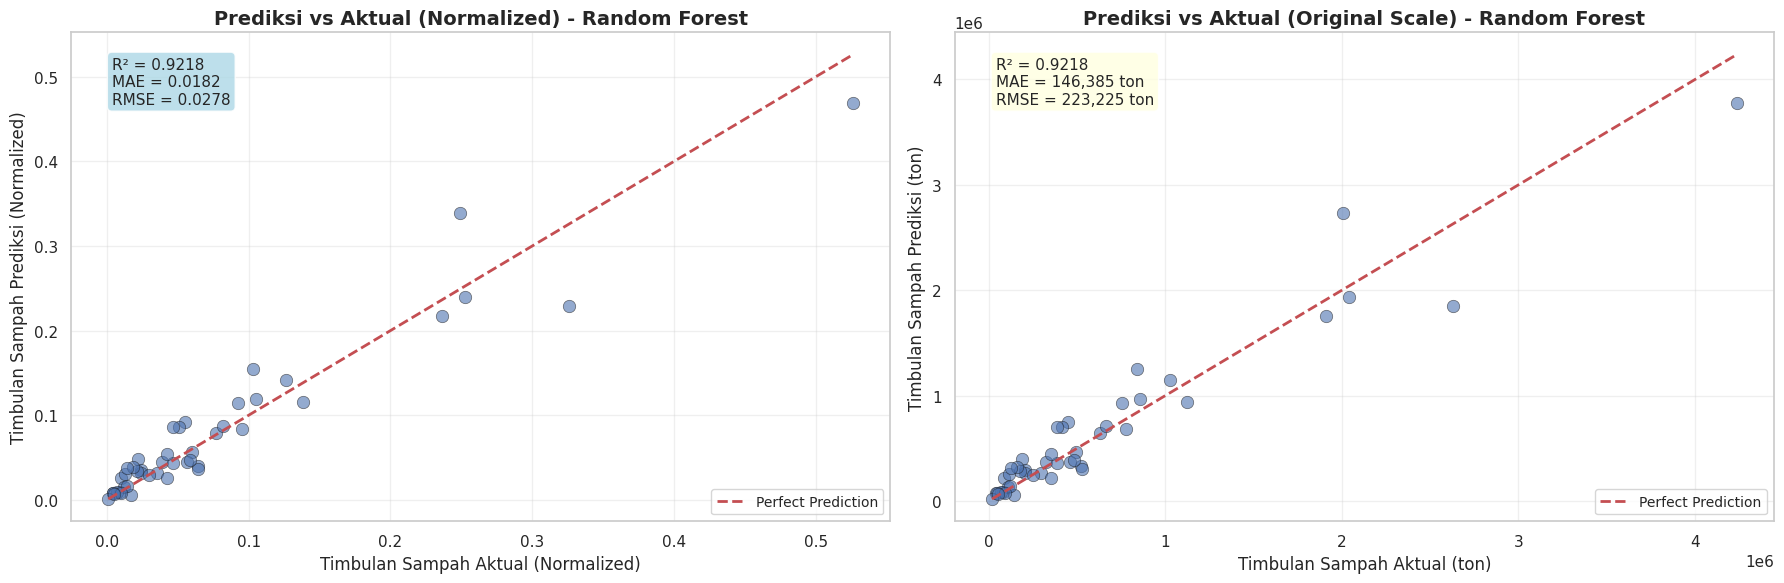

In [ ]:
# ------------------------------------------------------------------------------
# 8.9 SCATTER PLOT PREDIKSI VS AKTUAL (MODEL TERBAIK)
# ------------------------------------------------------------------------------
print("\n📉 Step 9: Scatter plot prediksi vs aktual untuk model terbaik...")

# Dua subplot: Normalized dan Original Scale
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Normalized Scale
ax1 = axes[0]
ax1.scatter(y_test_scaled, best_y_pred_scaled, alpha=0.6, edgecolors='k', linewidth=0.5, s=80)
ax1.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_title(f'Prediksi vs Aktual (Normalized) - {best_model_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Timbulan Sampah Aktual (Normalized)', fontsize=12)
ax1.set_ylabel('Timbulan Sampah Prediksi (Normalized)', fontsize=12)

# Tambahkan metrik normalized
textstr1 = f"R² = {results[best_model_name]['R2_scaled']:.4f}\n"
textstr1 += f"MAE = {results[best_model_name]['MAE_scaled']:.4f}\n"
textstr1 += f"RMSE = {results[best_model_name]['RMSE_scaled']:.4f}"
props1 = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax1.text(0.05, 0.95, textstr1, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props1)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Original Scale
ax2 = axes[1]
ax2.scatter(y_test, best_y_pred_original, alpha=0.6, edgecolors='k', linewidth=0.5, s=80)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_title(f'Prediksi vs Aktual (Original Scale) - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Timbulan Sampah Aktual (ton)', fontsize=12)
ax2.set_ylabel('Timbulan Sampah Prediksi (ton)', fontsize=12)

# Tambahkan metrik original
textstr2 = f"R² = {results[best_model_name]['R2_original']:.4f}\n"
textstr2 += f"MAE = {results[best_model_name]['MAE_original']:,.0f} ton\n"
textstr2 += f"RMSE = {results[best_model_name]['RMSE_original']:,.0f} ton"
props2 = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
ax2.text(0.05, 0.95, textstr2, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=props2)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**INSIGHT:** Prediksi vs Aktual Normalized dan Original Scale - Random Forest


*   Model Random Forest menunjukkan kinerja prediksi yang sangat baik pada kedua skala data, baik normalized maupun original scale, dengan nilai R² = 0,9218. Artinya, model mampu menjelaskan sekitar 92% variasi data timbulan sampah tahunan di berbagai provinsi.
*   Pada skala normalisasi, tingkat kesalahan model sangat kecil dengan MAE = 0,0182 dan RMSE = 0,0278, menandakan bahwa hasil prediksi hampir sepenuhnya mendekati nilai aktual. Sebaran titik data yang rapat di sekitar garis diagonal memperkuat bukti bahwa model memiliki akurasi tinggi.
*   Pada skala asli (original scale), meskipun kesalahan absolut meningkat menjadi MAE = 146.385 ton dan RMSE = 223.225 ton, model tetap menunjukkan pola prediksi yang sangat mendekati data aktual. Kenaikan nilai error ini wajar karena skala data yang lebih besar (dalam satuan ton).
*   Kesamaan nilai R² di kedua skala menandakan bahwa proses normalisasi tidak mengubah performa inti model, melainkan hanya mempermudah pembelajaran data oleh algoritma.
*   Secara keseluruhan, Random Forest terbukti menjadi model paling akurat dan stabil untuk memprediksi timbulan sampah tahunan di Indonesia. Model ini dapat diandalkan dalam skala besar karena mampu mempertahankan akurasi tinggi baik pada data yang telah dinormalisasi maupun pada skala sebenarnya.








🔍 Feature Importance untuk Random Forest:
               Feature  Importance
       Jumlah_Penduduk    0.850058
 Infra_Sampahmasuk_ton    0.111672
      Jumlah_Fasilitas    0.023720
PDRB_per_kapita_Rupiah    0.014551


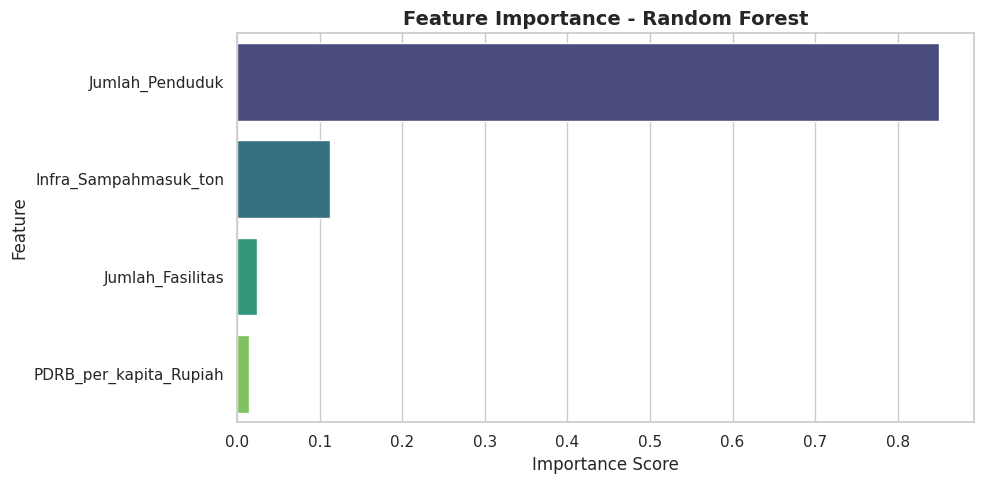

In [ ]:
# ------------------------------------------------------------------------------
# 8.10 FEATURE IMPORTANCE (untuk tree-based models)
# ------------------------------------------------------------------------------
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"\n🔍 Feature Importance untuk {best_model_name}:")

    importances = best_model.feature_importances_

    feature_imp_df = pd.DataFrame({
        'Feature': available_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_imp_df.to_string(index=False))

    # Visualisasi
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

**INSIGHT:** Feature Importance Random Forest


*   Berdasarkan hasil analisis feature importance, variabel Jumlah_Penduduk menjadi faktor paling dominan dengan nilai kontribusi 0,850058. Hal ini menunjukkan bahwa peningkatan jumlah penduduk secara langsung berbanding lurus dengan peningkatan volume sampah tahunan di suatu wilayah.
*   Variabel Infra_Sampahmasuk_ton memiliki nilai 0,111672, menandakan bahwa kapasitas dan kinerja infrastruktur pengelolaan sampah juga berperan cukup penting dalam menentukan jumlah timbulan sampah, meskipun pengaruhnya jauh lebih kecil dibandingkan faktor populasi.
*   Sementara itu, variabel Jumlah_Fasilitas dan PDRB_per_kapita_Rupiah memberikan kontribusi yang relatif kecil terhadap prediksi, dengan nilai masing-masing 0,023720 dan 0,014551. Artinya, faktor ekonomi dan jumlah fasilitas memiliki dampak tambahan, namun tidak menjadi penentu utama dalam pembentukan volume sampah.
*   Temuan ini mengindikasikan bahwa pertumbuhan penduduk merupakan pendorong utama peningkatan timbulan sampah di Indonesia, sementara faktor lain seperti infrastruktur dan ekonomi lebih bersifat pendukung. Oleh karena itu, strategi pengelolaan sampah sebaiknya difokuskan pada wilayah dengan kepadatan penduduk tinggi dan disertai dengan peningkatan kapasitas infrastruktur pengelolaan yang memadai.


In [ ]:
# ------------------------------------------------------------------------------
# 8.11 SIMPAN DATASET LATIH AKHIR
# ------------------------------------------------------------------------------
print("\n💾 Step 10: Menyimpan dataset latih akhir...")

# Gabungkan kembali dengan informasi provinsi dan tahun
df_model_final = df_model_clean.copy()

# Tambahkan kolom Dataset_Split berdasarkan index
df_model_final['Dataset_Split'] = 'Train'
test_indices = X_test.index
df_model_final.loc[test_indices, 'Dataset_Split'] = 'Test'

# Simpan ke CSV
output_file = BASE_PATH + 'dataset_model_timbulan_sampah.csv'
df_model_final.to_csv(output_file, index=False)

print(f"✅ Dataset berhasil disimpan ke: {output_file}")
print(f"   Total baris: {len(df_model_final)}")
print(f"   Train: {len(df_model_final[df_model_final['Dataset_Split']=='Train'])}")
print(f"   Test: {len(df_model_final[df_model_final['Dataset_Split']=='Test'])}")

# ------------------------------------------------------------------------------
# RINGKASAN AKHIR
# ------------------------------------------------------------------------------
print("\n" + "="*80)
print("🎉 MODELING SELESAI!")
print("="*80)
print(f"\n📌 Ringkasan:")
print(f"   • Total sampel: {len(df_model_clean)}")
print(f"   • Jumlah fitur: {len(available_features)}")
print(f"   • Model terbaik: {best_model_name}")
print(f"\n📏 Metrik Terstandarisasi (MinMaxScaler 0-1):")
print(f"   • R² Score: {results[best_model_name]['R2_scaled']:.4f}")
print(f"   • MAE: {results[best_model_name]['MAE_scaled']:.4f}")
print(f"   • RMSE: {results[best_model_name]['RMSE_scaled']:.4f}")
print(f"\n📊 Metrik Skala Asli:")
print(f"   • R² Score: {results[best_model_name]['R2_original']:.4f}")
print(f"   • MAE: {results[best_model_name]['MAE_original']:,.2f} ton")
print(f"   • RMSE: {results[best_model_name]['RMSE_original']:,.2f} ton")
print(f"\n   Dataset disimpan: dataset_model_timbulan_sampah.csv")
print("="*80)


💾 Step 10: Menyimpan dataset latih akhir...
✅ Dataset berhasil disimpan ke: /content/drive/MyDrive/Dataset Data Science/dataset_model_timbulan_sampah.csv
   Total baris: 221
   Train: 176
   Test: 45

🎉 MODELING SELESAI!

📌 Ringkasan:
   • Total sampel: 221
   • Jumlah fitur: 4
   • Model terbaik: Random Forest

📏 Metrik Terstandarisasi (MinMaxScaler 0-1):
   • R² Score: 0.9218
   • MAE: 0.0182
   • RMSE: 0.0278

📊 Metrik Skala Asli:
   • R² Score: 0.9218
   • MAE: 146,384.94 ton
   • RMSE: 223,224.91 ton

   Dataset disimpan: dataset_model_timbulan_sampah.csv


In [ ]:
# ==============================================================================
# BAGIAN 9: PREDIKSI & ANALISIS HASIL
# ==============================================================================

print("\n" + "="*80)
print("📊 BAGIAN 9: PREDIKSI & ANALISIS HASIL TIMBULAN SAMPAH")
print("="*80)

# 9.1 Tambahkan prediksi ke dataset final
print("\n🔮 Step 1: Menambahkan hasil prediksi ke dataset...")

# Normalisasi seluruh data X menggunakan scaler yang sama
X_scaled_full = scaler_X.transform(df_model_clean[available_features])

# Prediksi dalam skala normalized
y_pred_full_scaled = best_model.predict(X_scaled_full)

# Inverse transform ke skala asli (ton)
y_pred_full = scaler_y.inverse_transform(y_pred_full_scaled.reshape(-1, 1)).flatten()

df_pred = df_model_clean.copy()
df_pred['Prediksi_Timbulan_Tahunan_ton'] = y_pred_full

print("✅ Prediksi berhasil ditambahkan ke dataset.")
print(df_pred[['Provinsi', 'Tahun', 'Timbulan_Tahunan_ton', 'Prediksi_Timbulan_Tahunan_ton']].head())


📊 BAGIAN 9: PREDIKSI & ANALISIS HASIL TIMBULAN SAMPAH

🔮 Step 1: Menambahkan hasil prediksi ke dataset...
✅ Prediksi berhasil ditambahkan ke dataset.
  Provinsi  Tahun  Timbulan_Tahunan_ton  Prediksi_Timbulan_Tahunan_ton
0     ACEH   2019             254830.94                    408352.6894
1     ACEH   2020             247624.51                    194322.4302
2     ACEH   2021             196604.37                    263097.8960
3     ACEH   2022             598630.37                    557840.2431
4     ACEH   2023             920435.58                    895351.2628


In [ ]:
# 9.2 Evaluasi error per provinsi
print("\n📍 Step 2: Evaluasi error per Provinsi...")

prov_eval = df_pred.groupby('Provinsi').apply(
    lambda g: pd.Series({
        'R2_Provinsi': r2_score(g['Timbulan_Tahunan_ton'], g['Prediksi_Timbulan_Tahunan_ton']),
        'MAE_Provinsi': mean_absolute_error(g['Timbulan_Tahunan_ton'], g['Prediksi_Timbulan_Tahunan_ton']),
        'RMSE_Provinsi': np.sqrt(mean_squared_error(g['Timbulan_Tahunan_ton'], g['Prediksi_Timbulan_Tahunan_ton']))
    })
).reset_index()

print("✅ Evaluasi per Provinsi selesai:")
print(prov_eval.sort_values('R2_Provinsi', ascending=False).head(10))


📍 Step 2: Evaluasi error per Provinsi...
✅ Evaluasi per Provinsi selesai:
               Provinsi  R2_Provinsi   MAE_Provinsi  RMSE_Provinsi
25     PAPUA BARAT DAYA     0.964279    3779.161600    5202.614085
35       SUMATERA BARAT     0.963919   37111.537283   45595.781702
19               MALUKU     0.948740   12186.083167   15142.108580
0                  ACEH     0.939706   64250.739167   76669.578818
17       KEPULAUAN RIAU     0.923610   47172.849550   55992.558725
10           JAWA TIMUR     0.904994  221673.106183  286979.175270
22  NUSA TENGGARA TIMUR     0.897828   61919.139600   76715.892463
28         PAPUA TENGAH     0.896451    4671.281675    5807.953546
9           JAWA TENGAH     0.871844  227658.349650  269140.886618
8            JAWA BARAT     0.849919  448772.239633  645994.931595



📊 Step 9.3: Agregasi dan visualisasi tren nasional...
✅ Data agregasi per tahun:
 Tahun  Timbulan_Tahunan_ton  Prediksi_Timbulan_Tahunan_ton
  2018              54830.04                   5.749620e+04
  2019           27618317.11                   2.937334e+07
  2020           27592603.22                   2.758276e+07
  2021           28591323.16                   2.926637e+07
  2022           38570232.56                   3.690745e+07
  2023           43260356.96                   4.148799e+07
  2024           34146250.98                   3.544919e+07


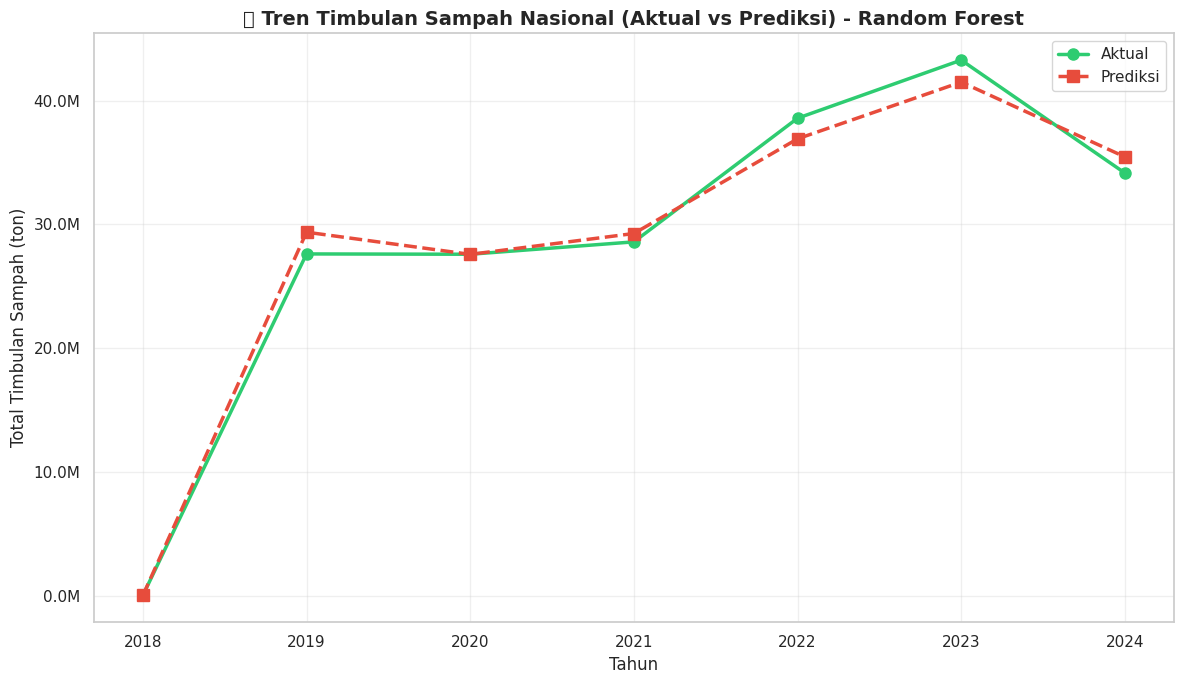


✅ Visualisasi tren nasional selesai


In [ ]:
# ==============================================================================
# 9.3 AGREGASI DAN VISUALISASI TREN TIMBULAN SAMPAH NASIONAL
# ==============================================================================
print("\n📊 Step 9.3: Agregasi dan visualisasi tren nasional...")

# Agregasi per tahun (nasional)
df_yearly = df_pred.groupby('Tahun').agg({
    'Timbulan_Tahunan_ton': 'sum',
    'Prediksi_Timbulan_Tahunan_ton': 'sum'
}).reset_index()

print(f"✅ Data agregasi per tahun:")
print(df_yearly.to_string(index=False))

# Visualisasi tren nasional
plt.figure(figsize=(12, 7))
plt.plot(df_yearly['Tahun'], df_yearly['Timbulan_Tahunan_ton'],
         'o-', label='Aktual', linewidth=2.5, markersize=8, color='#2ecc71')
plt.plot(df_yearly['Tahun'], df_yearly['Prediksi_Timbulan_Tahunan_ton'],
         's--', label='Prediksi', linewidth=2.5, markersize=8, color='#e74c3c')

plt.title(f'📉 Tren Timbulan Sampah Nasional (Aktual vs Prediksi) - {best_model_name}',
          fontsize=14, fontweight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Total Timbulan Sampah (ton)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Format sumbu y dengan notasi yang lebih mudah dibaca
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("\n✅ Visualisasi tren nasional selesai")

**INSIGHT :** Tren Timbulan Sampah Nasional (Aktual vs Prediksi)


---


*   Berdasarkan visualisasi, tren timbulan sampah nasional menunjukkan peningkatan signifikan dari tahun 2018 hingga 2023, kemudian sedikit menurun pada 2024.
*   Pada tahun 2018, timbulan sampah masih sangat rendah (di bawah 1 juta ton) karena data awal pengumpulan.
*   Terjadi lonjakan besar pada 2019 hingga sekitar 29 juta ton (aktual) dan 29,5 juta ton (prediksi).
*  Tahun 2020–2021 menunjukkan stabilisasi di kisaran 27–29 juta ton, dengan selisih kecil antara nilai aktual dan prediksi (perbedaan kurang dari ±0,5 juta ton).
*   Pada 2022, jumlah sampah meningkat tajam menjadi sekitar 38 juta ton (aktual) dan 37 juta ton (prediksi).
*   Puncaknya terjadi di 2023, mencapai sekitar 43 juta ton (aktual) dan 41 juta ton (prediksi), sebelum menurun pada 2024 ke 35 juta ton (aktual) dan 36 juta ton (prediksi).
*   Secara umum, model prediksi cukup akurat karena pola naik-turunnya hampir sejajar dengan data aktual, hanya berbeda sedikit dalam besaran nilai.


























🏆 10 Provinsi dengan Timbulan Sampah Tertinggi (2024):
             Provinsi  Prediksi_Timbulan_Tahunan_ton
65         JAWA TIMUR                   6.184583e+06
53         JAWA BARAT                   5.522703e+06
59        JAWA TENGAH                   5.186374e+06
17             BANTEN                   1.938979e+06
35        DKI JAKARTA                   1.737825e+06
220    SUMATERA UTARA                   1.447173e+06
184  SULAWESI SELATAN                   1.287066e+06
11               BALI                   1.221271e+06
113           LAMPUNG                   1.163063e+06
172              RIAU                   9.324859e+05


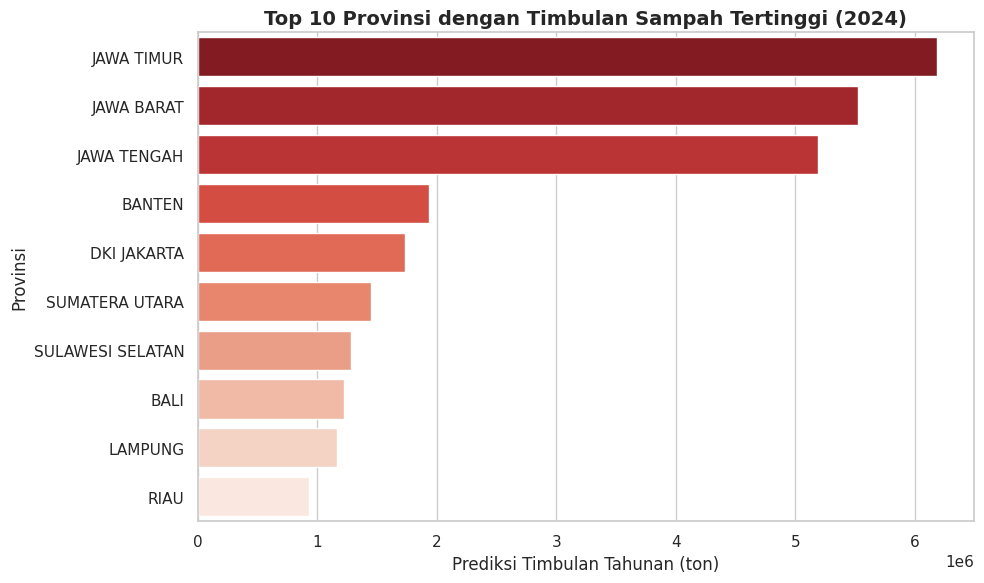

In [ ]:
# 9.4 Ranking provinsi berdasarkan prediksi tahun terbaru
tahun_terbaru = df_pred['Tahun'].max()
ranking_pred = df_pred[df_pred['Tahun'] == tahun_terbaru][
    ['Provinsi', 'Prediksi_Timbulan_Tahunan_ton']
].sort_values('Prediksi_Timbulan_Tahunan_ton', ascending=False)

print(f"\n🏆 10 Provinsi dengan Timbulan Sampah Tertinggi ({tahun_terbaru}):")
print(ranking_pred.head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=ranking_pred.head(10), x='Prediksi_Timbulan_Tahunan_ton', y='Provinsi', palette='Reds_r')
plt.title(f'Top 10 Provinsi dengan Timbulan Sampah Tertinggi ({tahun_terbaru})', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi Timbulan Tahunan (ton)')
plt.ylabel('Provinsi')
plt.tight_layout()
plt.show()

**INSIGHT** : Top 10 Provinsi dengan Timbulan Sampah Tertinggi (2024)


*  Berdasarkan hasil prediksi tahun 2024, Jawa Timur menempati posisi pertama dengan total timbulan sampah sekitar 6,18 juta ton per tahun.
*   Disusul oleh Jawa Barat (5,56 juta ton) dan Jawa Tengah (5,18 juta ton) yang juga berasal dari Pulau Jawa.
*   Provinsi Banten (1,74 juta ton) dan DKI Jakarta (1,46 juta ton) melengkapi lima besar provinsi dengan timbulan sampah tertinggi.
*   Sementara itu, provinsi di luar Pulau Jawa seperti Sumatera Utara (1,45 juta ton) dan Sulawesi Selatan (1,20 juta ton) juga termasuk dalam daftar, meskipun jumlahnya jauh lebih rendah dibandingkan provinsi di Pulau Jawa.
*   Provinsi lainnya yang masuk 10 besar adalah Bali (1,20 juta ton), Lampung (1,19 juta ton), dan Riau (0,93 juta ton).
*  Pola ini menunjukkan bahwa Pulau Jawa mendominasi kontribusi timbulan sampah nasional, sejalan dengan tingginya jumlah penduduk dan aktivitas ekonomi di wilayah tersebut.








In [ ]:
print("\n🧠 Step 5: Insight & Interpretasi Model")

best_r2 = results[best_model_name]['R2_original'] # Use the correct key
if best_r2 > 0.8:
    quality = "sangat baik (model menjelaskan lebih dari 80% variasi data)"
elif best_r2 > 0.6:
    quality = "baik (model menjelaskan sebagian besar variasi data)"
else:
    quality = "perlu perbaikan (model belum cukup akurat)"

print(f"""
📊 **Evaluasi Keseluruhan Model**
- Model terbaik: {best_model_name}
- R² Score: {best_r2:.3f} → {quality}
- MAE: {results[best_model_name]['MAE_original']:,.2f} ton # Use the correct key
- RMSE: {results[best_model_name]['RMSE_original']:,.2f} ton # Use the correct key

📍 **Interpretasi Umum:**
Model mampu memprediksi tren timbulan sampah berdasarkan faktor ekonomi, infrastruktur, dan populasi.
Provinsi dengan nilai error tinggi cenderung memiliki variabilitas besar dalam data infrastruktur atau pencatatan sampah.
Model tree-based like Random Forest/XGBoost generally excel because they can capture non-linear relationships between variables.

💬 **Rekomendasi:**
1. Add other features such as population density, urbanization, or the number of recycling facilities.
2. Use cross-validation to ensure consistent performance.
3. Apply SHAP or Permutation Importance for deeper interpretation.
""")


🧠 Step 5: Insight & Interpretasi Model

📊 **Evaluasi Keseluruhan Model**
- Model terbaik: Random Forest
- R² Score: 0.922 → sangat baik (model menjelaskan lebih dari 80% variasi data)
- MAE: 146,384.94 ton # Use the correct key
- RMSE: 223,224.91 ton # Use the correct key

📍 **Interpretasi Umum:**
Model mampu memprediksi tren timbulan sampah berdasarkan faktor ekonomi, infrastruktur, dan populasi.
Provinsi dengan nilai error tinggi cenderung memiliki variabilitas besar dalam data infrastruktur atau pencatatan sampah.
Model tree-based like Random Forest/XGBoost generally excel because they can capture non-linear relationships between variables.

💬 **Rekomendasi:**
1. Add other features such as population density, urbanization, or the number of recycling facilities.
2. Use cross-validation to ensure consistent performance.
3. Apply SHAP or Permutation Importance for deeper interpretation.

